# Trabalho 1 da disciplina de Machine Learning com tema: Predição do preço de corridas de Uber e Lyft
### OBJETIVO: prever o valor esperado de uma corrida com base nos outros dados disponíveis, tendo como métrica a ser otimizada o MAPE (Mean Absolute Percentage Error).


In [1]:
""" Importando as Bibliotecas """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatLogSlider

#Biblotecas sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures



## Parte 1 - Carregar os dados

In [2]:
#Carregando os dados
file = '../rideshare_kaggle.csv'
df = pd.read_csv(file)

In [3]:
# Removendo as colunas requisitadas
df.drop(columns=['timezone', 'datetime', 'product_id', 'latitude', 'longitude', 'id'], inplace = True)


In [4]:
""" 
Observando so atributos percebemos que os mesmos são muitos e provavelmente vários deles não terão uma correlação muito alta com a saída
Acredito que no decorrer do trabalho serei capaz de identificar e remover os atributos desnecessários ou pouco influentes no cálculo
 """
print(df.columns)

Index(['timestamp', 'hour', 'day', 'month', 'source', 'destination',
       'cab_type', 'name', 'price', 'distance', 'surge_multiplier',
       'temperature', 'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime'],
      dtype='object')


In [5]:
""" Não me diz muita coisa pois temos mais colunas do que ele consegue mostrar """
df.head()

,timestamp,hour,day,month,source,destination,cab_type,name,price,distance,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,1.544953e+09,9,16,12,Haymarket Square,North Station,Lyft,Shared,5.0,0.44,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,1.543284e+09,2,27,11,Haymarket Square,North Station,Lyft,Lux,11.0,0.44,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,1.543367e+09,1,28,11,Haymarket Square,North Station,Lyft,Lyft,7.0,0.44,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,1.543554e+09,4,30,11,Haymarket Square,North Station,Lyft,Lux Black XL,26.0,0.44,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,1.543463e+09,3,29,11,Haymarket Square,North Station,Lyft,Lyft XL,9.0,0.44,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [6]:
""" Apesar de não conseguir visualizar todas as colunas sem abrir um editor de texto com o df.describe pode se ter uma noção dos valores de cada atributo """
df.describe()

,timestamp,hour,day,month,price,distance,surge_multiplier,temperature,apparentTemperature,precipIntensity,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
count,6.930710e+05,693071.000000,693071.000000,693071.000000,637976.000000,693071.000000,693071.000000,693071.000000,693071.000000,693071.000000,...,693071.000000,6.930710e+05,693071.000000,6.930710e+05,693071.000000,6.930710e+05,693071.000000,6.930710e+05,693071.000000,6.930710e+05
mean,1.544046e+09,11.619137,17.794365,11.586684,16.545125,2.189430,1.013870,39.584388,35.881222,0.008922,...,0.037374,1.544044e+09,33.457774,1.544042e+09,45.261313,1.544047e+09,29.731002,1.544048e+09,41.997343,1.544048e+09
std,6.891925e+05,6.948114,9.982286,0.492429,9.324359,1.138937,0.091641,6.726084,7.918707,0.026901,...,0.055214,6.912028e+05,6.467224,6.901954e+05,5.645046,6.901353e+05,7.110494,6.871862e+05,6.936841,6.910777e+05
min,1.543204e+09,0.000000,1.000000,11.000000,2.500000,0.020000,1.000000,18.910000,12.130000,0.000000,...,0.000000,1.543162e+09,15.630000,1.543122e+09,33.510000,1.543154e+09,11.810000,1.543136e+09,28.950000,1.543187e+09
25%,1.543444e+09,6.000000,13.000000,11.000000,9.000000,1.280000,1.000000,36.450000,31.910000,0.000000,...,0.000000,1.543421e+09,30.170000,1.543399e+09,42.570000,1.543439e+09,27.760000,1.543399e+09,36.570000,1.543439e+09
50%,1.543737e+09,12.000000,17.000000,12.000000,13.500000,2.160000,1.000000,40.490000,35.900000,0.000000,...,0.000400,1.543770e+09,34.240000,1.543727e+09,44.680000,1.543788e+09,30.130000,1.543745e+09,40.950000,1.543788e+09
75%,1.544828e+09,18.000000,28.000000,12.000000,22.500000,2.920000,1.000000,43.580000,40.080000,0.000000,...,0.091600,1.544807e+09,38.880000,1.544789e+09,46.910000,1.544814e+09,35.710000,1.544789e+09,44.120000,1.544818e+09
max,1.545161e+09,23.000000,30.000000,12.000000,97.500000,7.860000,3.000000,57.220000,57.220000,0.144700,...,0.145900,1.545152e+09,43.100000,1.545192e+09,57.870000,1.545109e+09,40.050000,1.545134e+09,57.200000,1.545109e+09


In [7]:
""" Podemos perceber que estamos lidando com uma base de dados grande 693070 entradas e que contém 3 tipos de dados:
float, int e object """
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   timestamp                    693071 non-null  float64
 1   hour                         693071 non-null  int64  
 2   day                          693071 non-null  int64  
 3   month                        693071 non-null  int64  
 4   source                       693071 non-null  object 
 5   destination                  693071 non-null  object 
 6   cab_type                     693071 non-null  object 
 7   name                         693071 non-null  object 
 8   price                        637976 non-null  float64
 9   distance                     693071 non-null  float64
 10  surge_multiplier             693071 non-null  float64
 11  temperature                  693071 non-null  float64
 12  apparentTemperature          693071 non-null  float64
 13 

## Parte 2 - EDA Inicial

### a)

44


array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'distance'}>,
        <Axes: title={'center': 'surge_multiplier'}>,
        <Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'apparentTemperature'}>,
        <Axes: title={'center': 'precipIntensity'}>],
       [<Axes: title={'center': 'precipProbability'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windSpeed'}>,
        <Axes: title={'center': 'windGust'}>,
        <Axes: title={'center': 'windGustTime'}>],
       [<Axes: title={'center': 'visibility'}>,
        <Axes: title={'center': 'temperatureHigh'}>,
        <Axes: title={'center': 'temperatureHighTime'}>,
        <Axes: title={'center': 'temperatureLow'}>,
        <Axes: title={'center': 'temperatureLowTime'}>],
       [<Ax

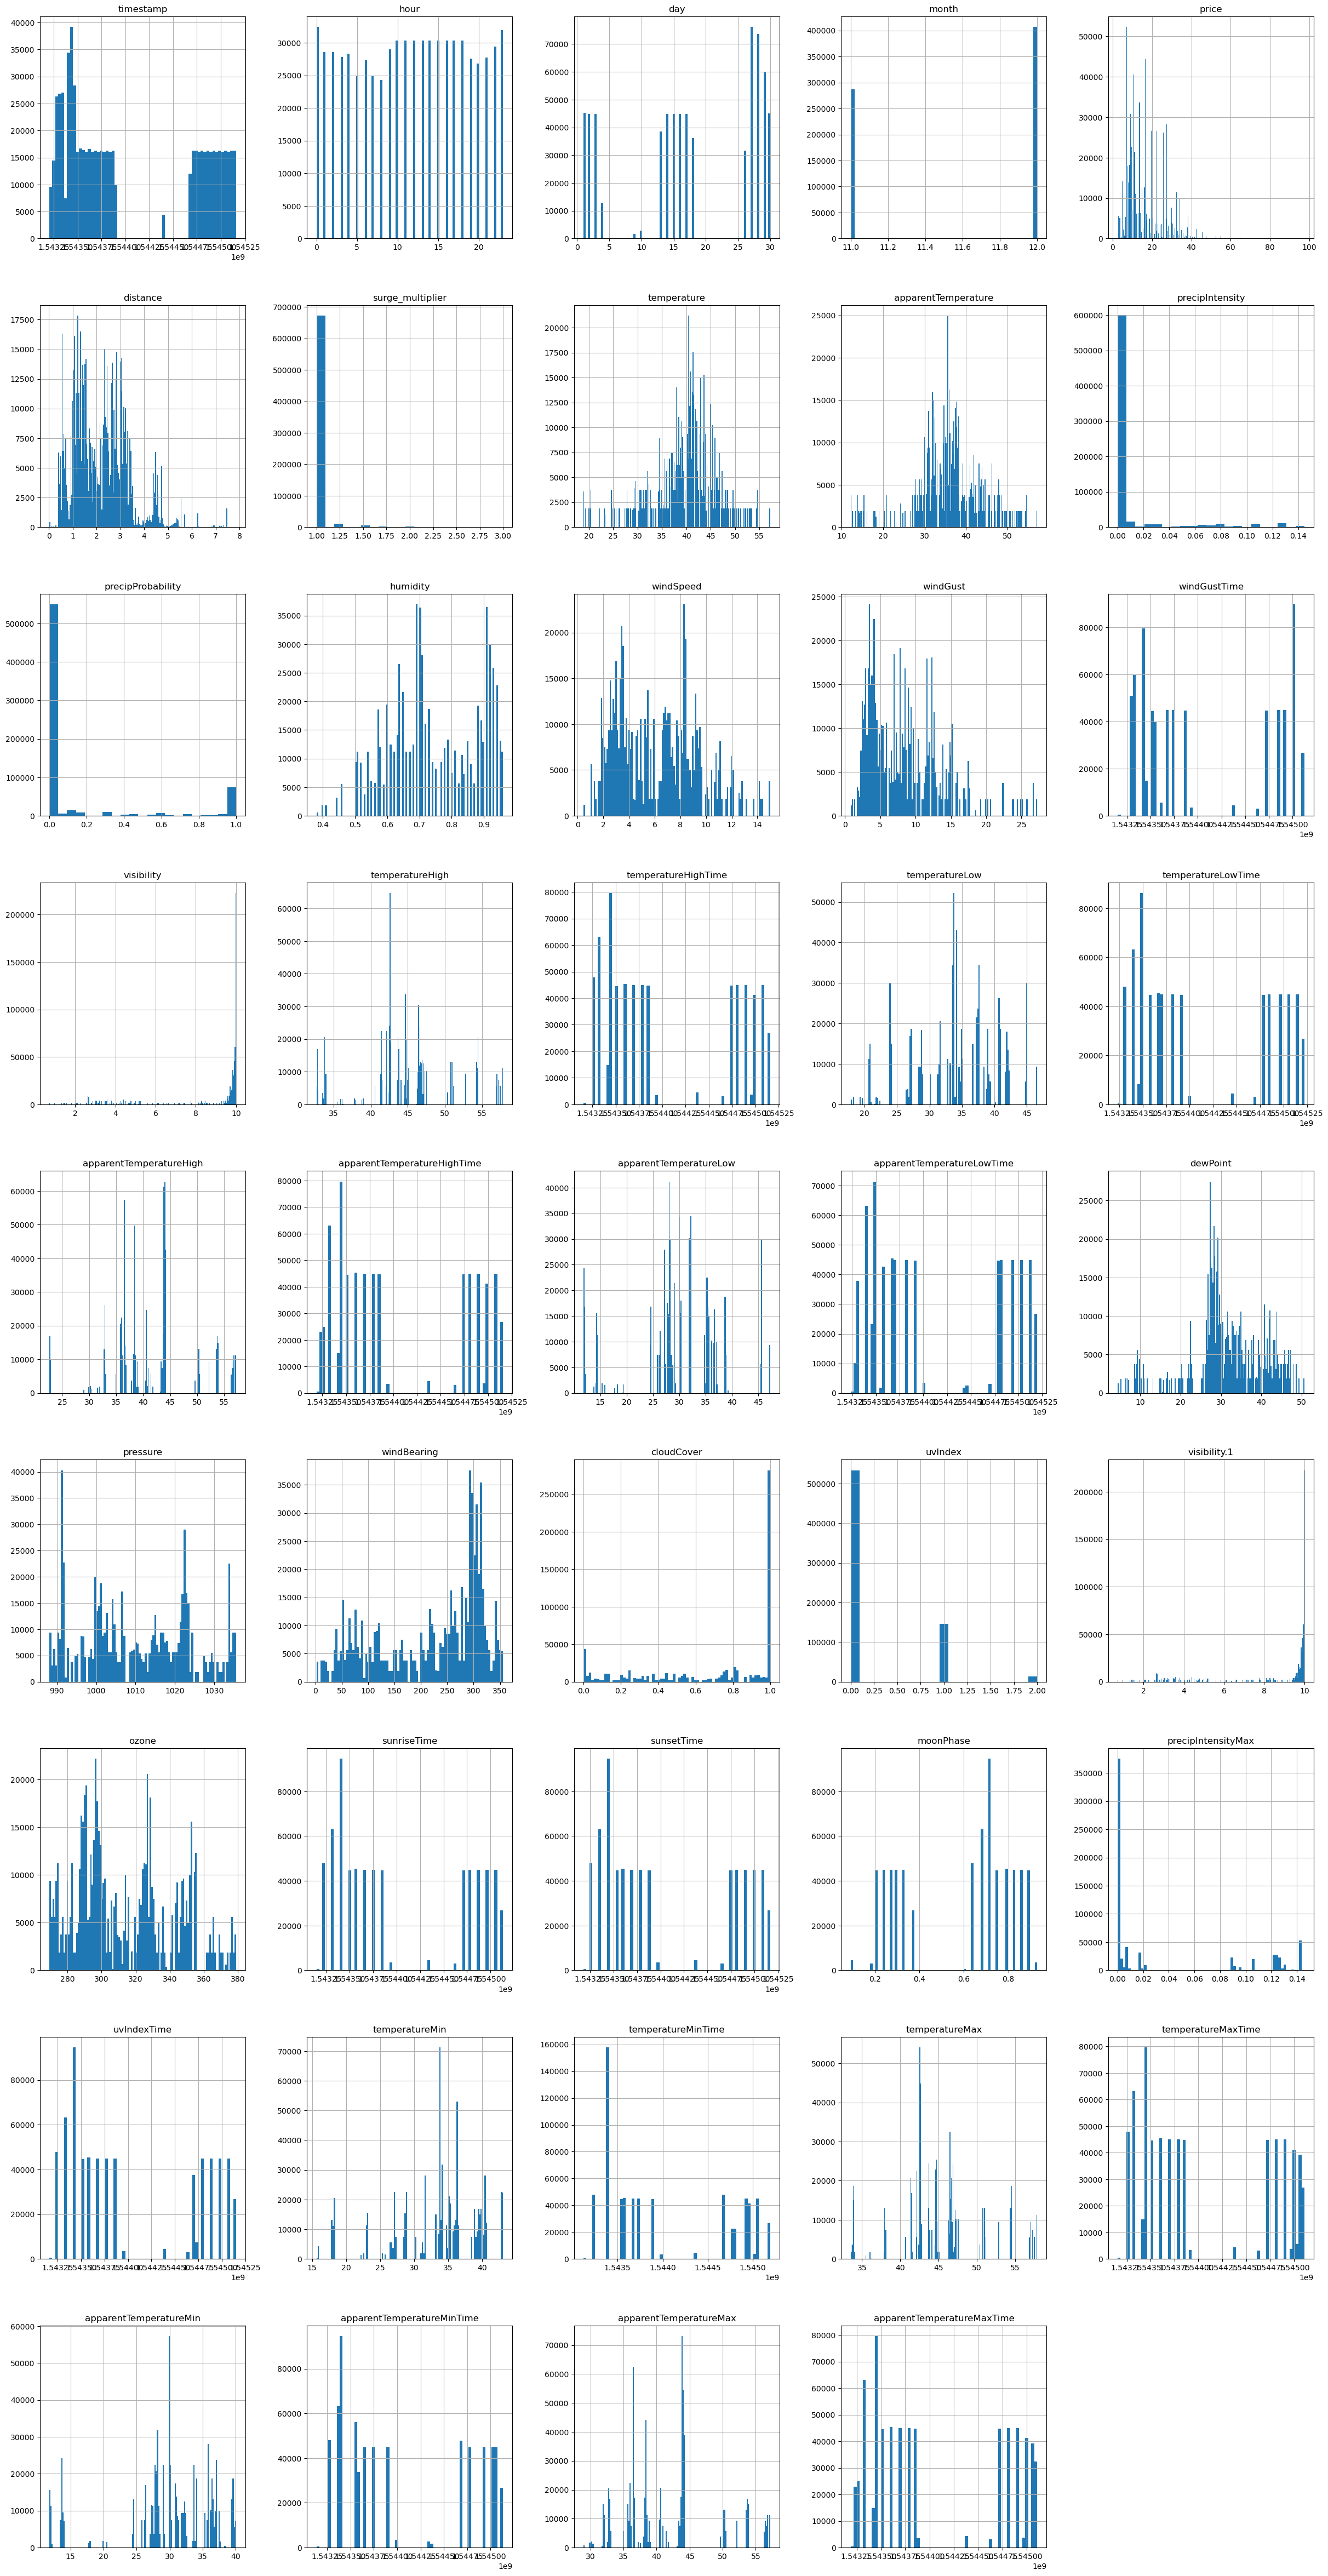

In [8]:
""" Primeiro irei realizar um for para contar quantas colunas possuem dados numéricos como temos apenas 3 tipos de dados e o único que não é numerico é o object, podemos utilizar deste fato para contar os mesmos """
count = 0
for coluna in df.columns:
    if df[coluna].dtype != object:
        count += 1
print (count)

""" Temos que printar o histograma de todas as variáveis numéricas, para isso irei utilizar o parametro bins = 'auto'
uma figsize de 30,60 e um layout de 9 linhas por 5 colunas pois se trata de 44 colunas com dados numéricos
Com isso podemos printar os histogramas dos dados """
df.hist(bins='auto', figsize=(30,60), layout=(9,5))





### b) Variaveis categóricas

In [9]:
""" Verificando agoras variáveis categóricas utilizei o df.describe com include = 'object' para pegar apenas as variáveis categóricas e não as numéricas as quais já verificamos anteriormente """
df.describe(include='object')


,source,destination,cab_type,name,short_summary,long_summary,icon
count,693071,693071,693071,693071,693071,693071,693071
unique,12,12,2,13,9,11,7
top,Financial District,Financial District,Uber,UberXL,Overcast,Mostly cloudy throughout the day.,cloudy
freq,58857,58851,385663,55096,218895,202340,218895


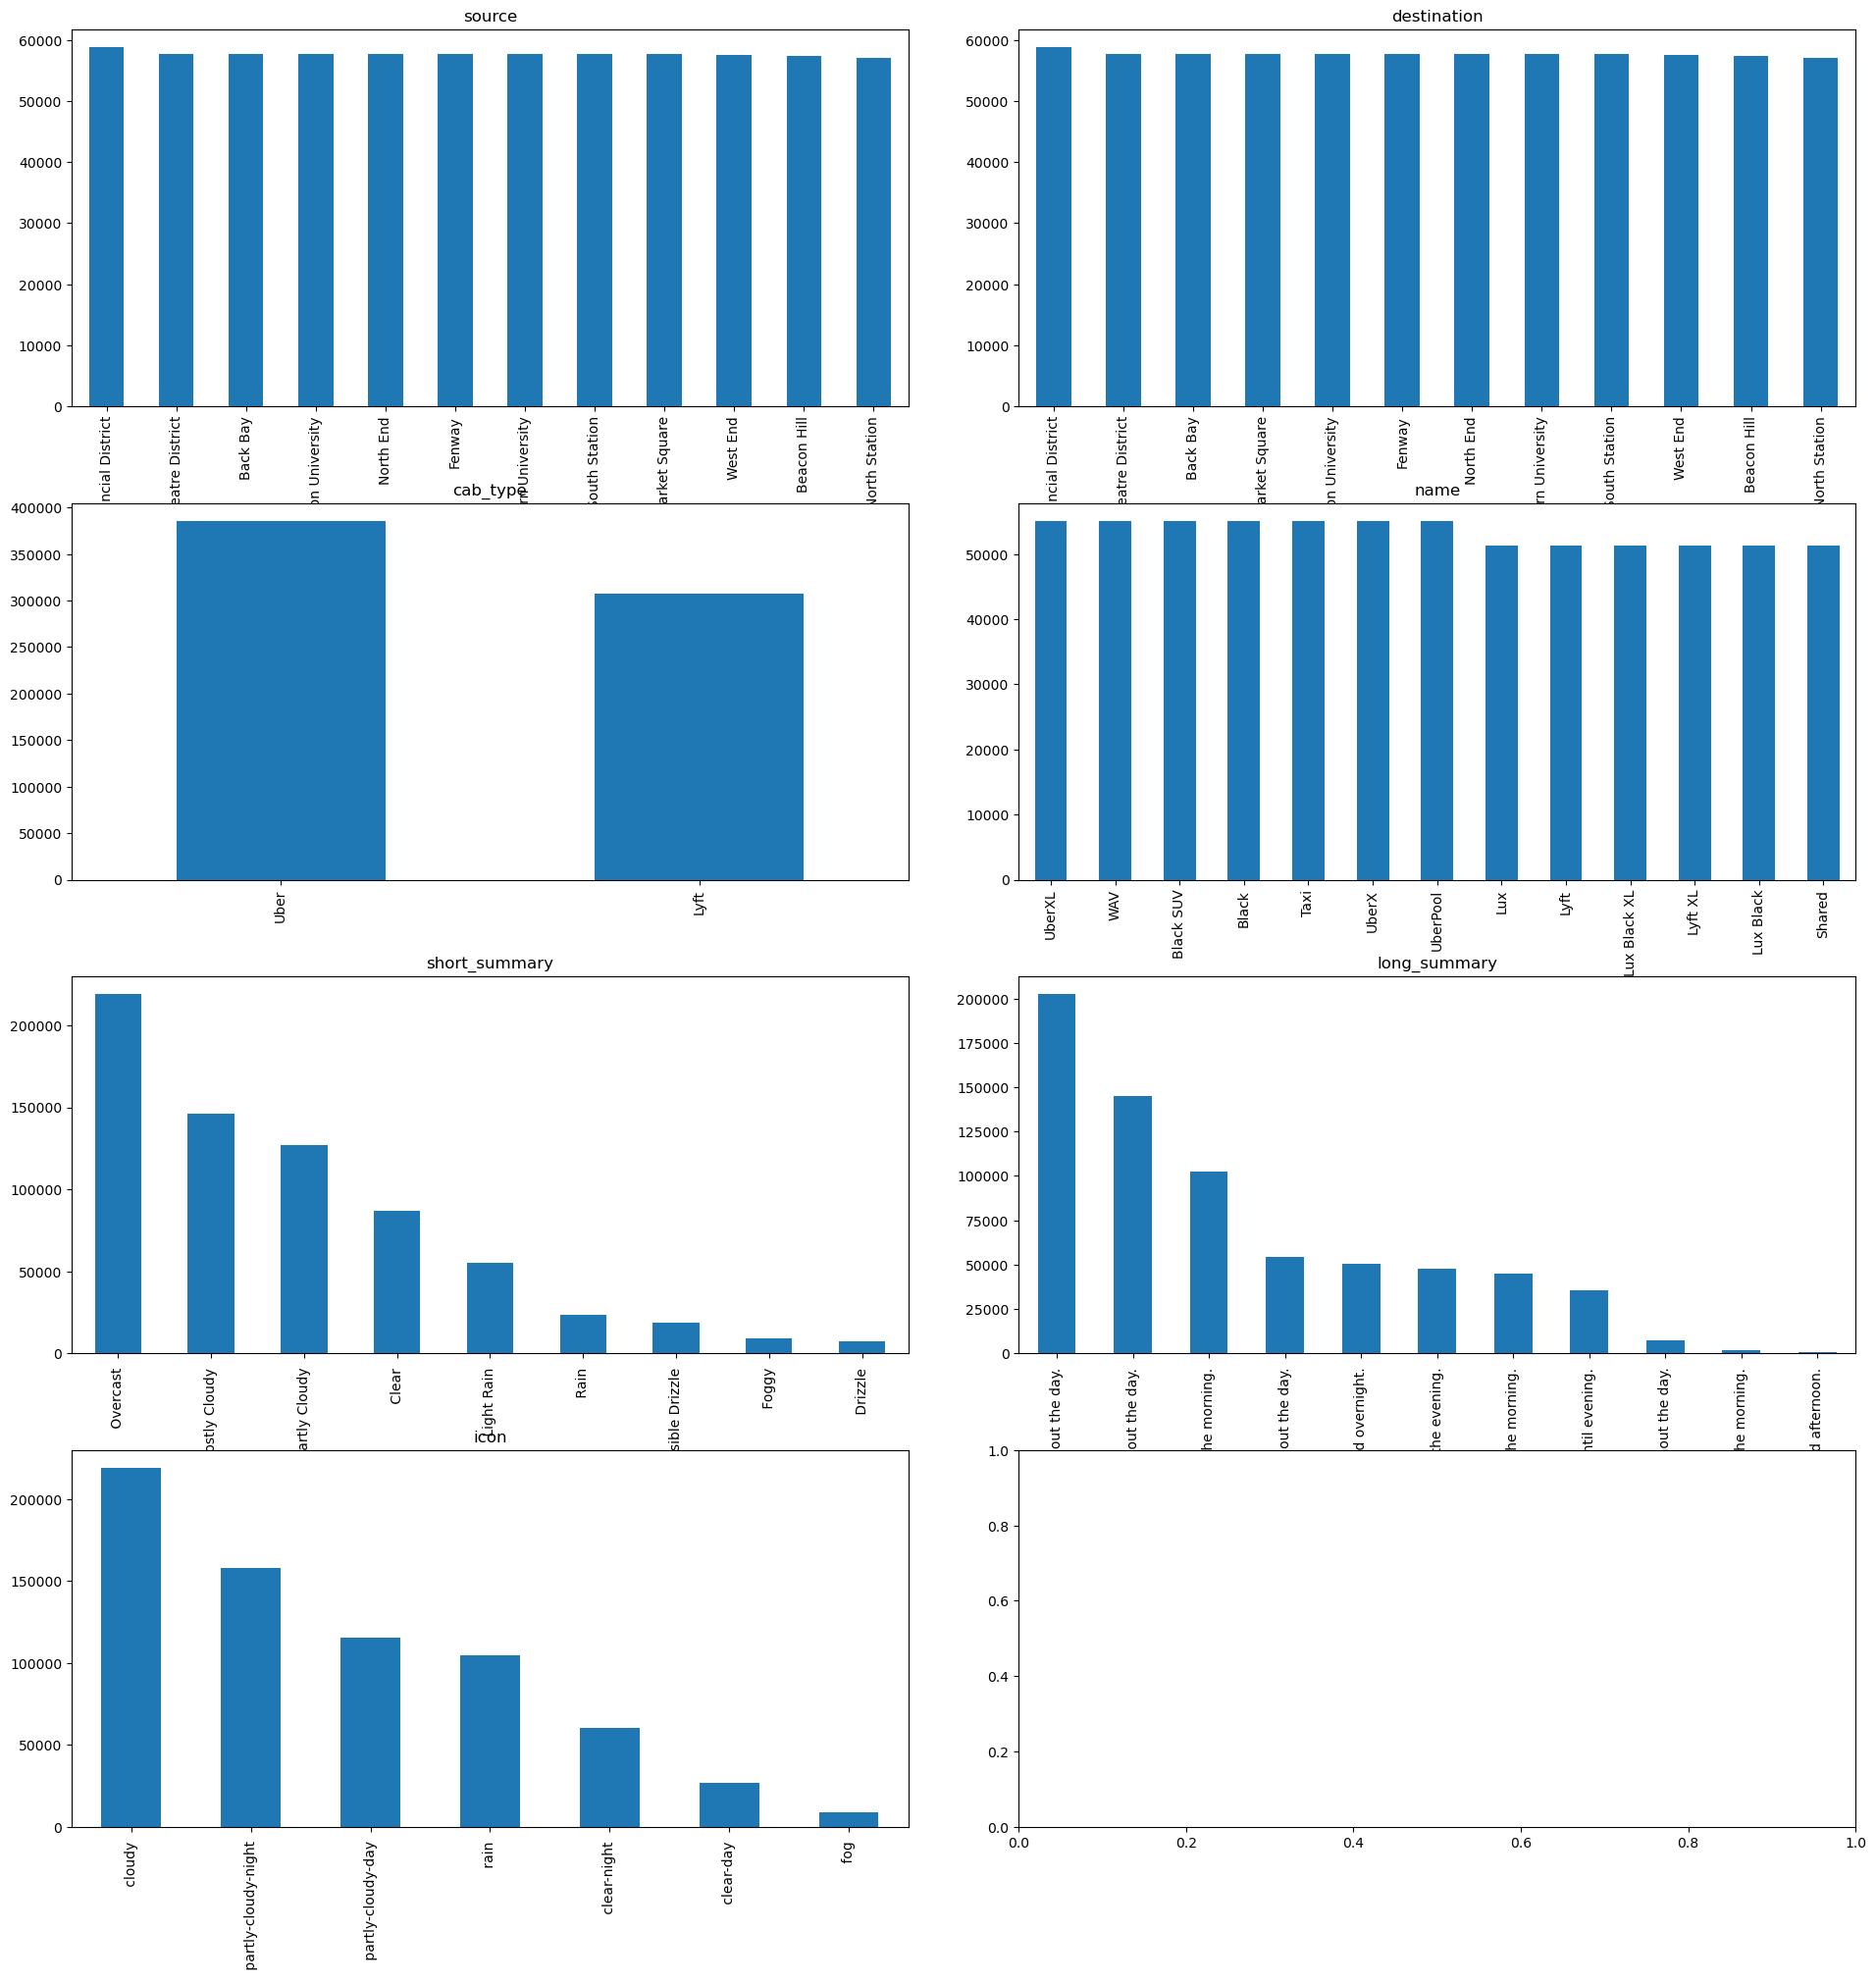

In [10]:
#Selecionei apena as variaveis categóricas em um novo dataframe para facilitar na hora do for
df_categoricas = df.select_dtypes(include='object')

#Como temos 7 variaveis irei utilizar 4 linhas e 2 colunas
row_num = 4
col_num = 2

#Definindo o tamanho da figura e o número de eixos do plt.subplot
fig, axes = plt.subplots(row_num, col_num, figsize=(20,20))
fig.tight_layout(pad=5.0)

#Fazendo uma rotina para printar um gráfico de barra para cada variável categórica
row_n = -1
for ix,coluna in enumerate(df_categoricas.columns):
    col_n = ix % col_num
    if col_n == 0:
        row_n = row_n + 1
    df_categoricas[coluna].value_counts().plot(kind='bar', x=col_n, ax=axes[row_n, col_n], title=coluna)
   
plt.show()


### c) Dados Duplicados

In [11]:
#Podemos utilizar a função duplicated() do pandas para fazer a verificação de dados duplicados
duplicateRows = df[df.duplicated()] #Estou criando um novo dataframe com apenas as linhas duplicadas para criar um dataframe sem as linhas duplicadas bastaria colocar um '~' dentro dos []
duplicateRows.info()#Temos 1660 Linhas duplicadas no dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1660 entries, 12966 to 692714
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   timestamp                    1660 non-null   float64
 1   hour                         1660 non-null   int64  
 2   day                          1660 non-null   int64  
 3   month                        1660 non-null   int64  
 4   source                       1660 non-null   object 
 5   destination                  1660 non-null   object 
 6   cab_type                     1660 non-null   object 
 7   name                         1660 non-null   object 
 8   price                        1047 non-null   float64
 9   distance                     1660 non-null   float64
 10  surge_multiplier             1660 non-null   float64
 11  temperature                  1660 non-null   float64
 12  apparentTemperature          1660 non-null   float64
 13  short_summar

### d) Dados Faltantes

In [12]:
lista = df.isna().sum()
print(lista.keys(), lista.values)
#Podemos verificar que temos 55095 amostras NaN apenas na variável "price"

Index(['timestamp', 'hour', 'day', 'month', 'source', 'destination',
       'cab_type', 'name', 'price', 'distance', 'surge_multiplier',
       'temperature', 'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime'],
      dtype='object') [    0     0  

### e) Outros pontos encontrados
Nas variáveis categóricas temos diversos valores únicos o que irá aumentar ainda mais o número de colunas fato que futuramente irei ter cuidado.

Temos dados faltantes e dados duplicados como visto anteriormente, além de um número de colunas muito grande o que pode gerar problemas na parte de treinamento dos algoritmos.

## Parte 3 - Limpar e separar o dataset



### a)

### b) Removendo dados faltantes

In [13]:
# Removendo linhas com dados faltantes
print('Num de linhas com NaN',len(df.index))
df.dropna(inplace=True)
print('Num de linhas sem NaN',len(df.index))
#Verificando
df.isna().any()

Num de linhas com NaN 693071
Num de linhas sem NaN 637976


timestamp                      False
hour                           False
day                            False
month                          False
source                         False
destination                    False
cab_type                       False
name                           False
price                          False
distance                       False
surge_multiplier               False
temperature                    False
apparentTemperature            False
short_summary                  False
long_summary                   False
precipIntensity                False
precipProbability              False
humidity                       False
windSpeed                      False
windGust                       False
windGustTime                   False
visibility                     False
temperatureHigh                False
temperatureHighTime            False
temperatureLow                 False
temperatureLowTime             False
apparentTemperatureHigh        False
a

### c) Remover Linhas duplicadas

In [14]:
len(df.index)

637976

In [15]:

df = df[~df.duplicated()]
df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            693059, 693061, 693062, 693063, 693064, 693065, 693066, 693067,
            693069, 693070],
           dtype='int64', length=636929)

### d) Reduzindo o dataframe

In [16]:
#Utilizando o código fornecido
# parâmetros
num_instancias_por_classe = 3000
# cria datasets auxiliares para reduzir o dataset para o tamanho desejado
df_temp = []
for classe in df['name'].unique():
    # seleciona parcela do dataset da classe desejada
    temp = df[df['name'] == classe].sample(n=num_instancias_por_classe,random_state=42)
    # salva para concatenar no final
    df_temp.append(temp)
    # concatena todos as subparcelas no dataset com tamanho desejado
df_small = pd.concat(df_temp, axis=0)
# confirma a divisão correta por classe
print('-'*30)
print('#instâncias em relação a coluna name')
print(df_small['name'].value_counts())
print('-'*30)
# mostra o dataset
df_small

------------------------------
#instâncias em relação a coluna name
Shared          3000
Lux             3000
Lyft            3000
Lux Black XL    3000
Lyft XL         3000
Lux Black       3000
UberXL          3000
Black           3000
UberX           3000
WAV             3000
Black SUV       3000
UberPool        3000
Name: name, dtype: int64
------------------------------


,timestamp,hour,day,month,source,destination,cab_type,name,price,distance,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
277878,1.543296e+09,5,27,11,North End,West End,Lyft,Shared,2.5,1.27,...,0.1430,1543338000,36.34,1543377600,47.11,1543320000,32.26,1543377600,44.14,1543320000
284360,1.544902e+09,19,15,12,Northeastern University,North Station,Lyft,Shared,7.0,3.26,...,0.0082,1544893200,39.74,1544929200,54.29,1544896800,37.04,1544929200,53.62,1544896800
322047,1.543466e+09,4,29,11,Fenway,Back Bay,Lyft,Shared,3.5,1.52,...,0.0000,1543420800,33.70,1543399200,42.60,1543438800,29.88,1543399200,36.56,1543435200
226416,1.543358e+09,22,27,11,North End,Beacon Hill,Lyft,Shared,7.0,2.39,...,0.1422,1543338000,35.90,1543377600,46.72,1543320000,31.81,1543377600,43.70,1543320000
324330,1.543718e+09,2,2,12,Theatre District,Northeastern University,Lyft,Shared,9.0,2.94,...,0.0000,1543683600,30.17,1543662000,44.11,1543690800,25.87,1543662000,43.44,1543690800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641728,1.544756e+09,2,14,12,Boston University,North Station,Uber,UberPool,9.0,3.39,...,0.0001,1544716800,18.24,1544688000,33.96,1544731200,13.72,1544688000,32.95,1544734800
440208,1.544725e+09,18,13,12,Financial District,South Station,Uber,UberPool,6.5,0.47,...,0.0001,1544720400,17.85,1544688000,33.78,1544731200,13.73,1544688000,33.11,1544731200
37155,1.544895e+09,17,15,12,West End,Haymarket Square,Uber,UberPool,11.0,0.72,...,0.0077,1544893200,39.80,1544929200,54.29,1544896800,36.78,1544929200,53.62,1544896800
314283,1.543643e+09,5,1,12,Fenway,Back Bay,Uber,UberPool,7.0,1.60,...,0.0000,1543683600,31.55,1543658400,44.72,1543690800,27.95,1543658400,44.05,1543690800


### e) Separe os conjuntos de treinamento, validação e teste
exatamente o mesmo tamanho (12000), fazendo a divisão estratificada em
função do atributo name e utilizando o random_state igual a 42, da seguinte forma:

#### i) Faça uma divisão estratificada entre treinamento e teste

In [17]:
""" Realizando uma divisão utilizadno a função train_test_split em cima do dataframe df_small
Com um test_size de 1/3, estratificada no atributo name e com o random_state de 42 """
df_train, df_test = train_test_split(df_small, test_size=1/3, stratify=df_small['name'], random_state=42)

#### ii) Faça uma divisão estratificada do conjunto de treinamento entre treinamento e validação

In [18]:
""" Como sobraram 24000 amostrars, iremos utilizar o test_size (que no caso é o tamanho dos dados de validação) igual a 50% e o resto fica igual a divisão anterior"""
df_train, df_validation = train_test_split(df_train, test_size=0.5, stratify=df_train['name'], random_state=42)

In [19]:
print(df_train.shape, df_validation.shape)

(12000, 51) (12000, 51)


### f) Separe os dados entre X e y


In [20]:
target = 'price' #Definindo a coluna que será predita
X_train = df_train.drop(target, axis=1) # X vai ser todas as colunas menos a coluna target
y_train = df_train[target] # y será apenas a coluna target


X_test = df_test.drop(target, axis=1)
y_test = df_test[target]


X_validation = df_validation.drop(target, axis=1)
y_validation = df_validation[target]


### g) Mostre o shape do X e y para o treinamento, validação e teste 

In [21]:
#Podemos verificar que todos tem o mesmo tamanho e com as colunas corretas
print("Treino:")
print(X_train.shape, y_train.shape)

print("Validação:")
print(X_validation.shape, y_validation.shape)

print("Teste:")
print(X_test.shape, y_test.shape)

Treino:
(12000, 50) (12000,)
Validação:
(12000, 50) (12000,)
Teste:
(12000, 50) (12000,)


## Parte 4 EDA no conjunto de treinamento

### a) Observe as correlações das variáveis numéricas com a saída (utilizar a função df.corr, podendo utilizar ou não a função heatmap do seaborn)

In [22]:
#Primeiro temos que selecionar somente as variaveis numéricas e utilizar a função .corr()
corr_num = df_train.select_dtypes(exclude='object').corr()
corr_num

,timestamp,hour,day,month,price,distance,surge_multiplier,temperature,apparentTemperature,precipIntensity,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
timestamp,1.000000,-0.012606,-0.332727,0.765901,0.006584,0.008350,0.004418,-0.245791,-0.224911,-0.168043,...,-0.203509,0.999372,-0.299824,0.998209,-0.185893,0.999289,-0.374659,0.998307,-0.159311,0.999275
hour,-0.012606,1.000000,0.059854,-0.067130,-0.014835,-0.003440,0.005209,0.223543,0.203263,-0.236199,...,0.015079,-0.012191,0.011551,-0.011280,0.005099,-0.012688,0.011822,-0.012357,0.007514,-0.012577
day,-0.332727,0.059854,1.000000,-0.860879,-0.022024,-0.004426,-0.011248,-0.087282,-0.225571,0.083764,...,0.142758,-0.332573,0.033842,-0.325191,-0.312306,-0.335956,-0.024726,-0.326018,-0.451525,-0.335854
month,0.765901,-0.067130,-0.860879,1.000000,0.018830,0.007588,0.009934,-0.077564,0.028163,-0.142949,...,-0.207141,0.765451,-0.184942,0.759785,0.112104,0.767717,-0.185468,0.760422,0.221098,0.767638
price,0.006584,-0.014835,-0.022024,0.018830,1.000000,0.338895,0.231704,-0.000255,0.001236,0.005119,...,-0.006680,0.006610,-0.004157,0.006513,0.009705,0.006715,0.000061,0.006334,0.011062,0.006710
distance,0.008350,-0.003440,-0.004426,0.007588,0.338895,1.000000,0.012105,-0.000983,-0.002713,-0.006370,...,-0.005906,0.007712,-0.008895,0.007969,-0.004571,0.007698,-0.009352,0.007700,-0.007754,0.007659
surge_multiplier,0.004418,0.005209,-0.011248,0.009934,0.231704,0.012105,1.000000,-0.011476,-0.013017,-0.009662,...,-0.009329,0.004691,-0.016978,0.005104,-0.008147,0.004240,-0.019756,0.004274,-0.004532,0.004372
temperature,-0.245791,0.223543,-0.087282,-0.077564,-0.000255,-0.000983,-0.011476,1.000000,0.947045,0.179364,...,0.329497,-0.251935,0.791170,-0.240117,0.781444,-0.251224,0.817750,-0.228820,0.705159,-0.252633
apparentTemperature,-0.224911,0.203263,-0.225571,0.028163,0.001236,-0.002713,-0.013017,0.947045,1.000000,0.095022,...,0.254382,-0.230275,0.700018,-0.223539,0.794635,-0.226631,0.787133,-0.211313,0.784274,-0.227593
precipIntensity,-0.168043,-0.236199,0.083764,-0.142949,0.005119,-0.006370,-0.009662,0.179364,0.095022,1.000000,...,0.493086,-0.169720,0.242000,-0.173002,0.112814,-0.171129,0.230238,-0.160019,0.106762,-0.172147


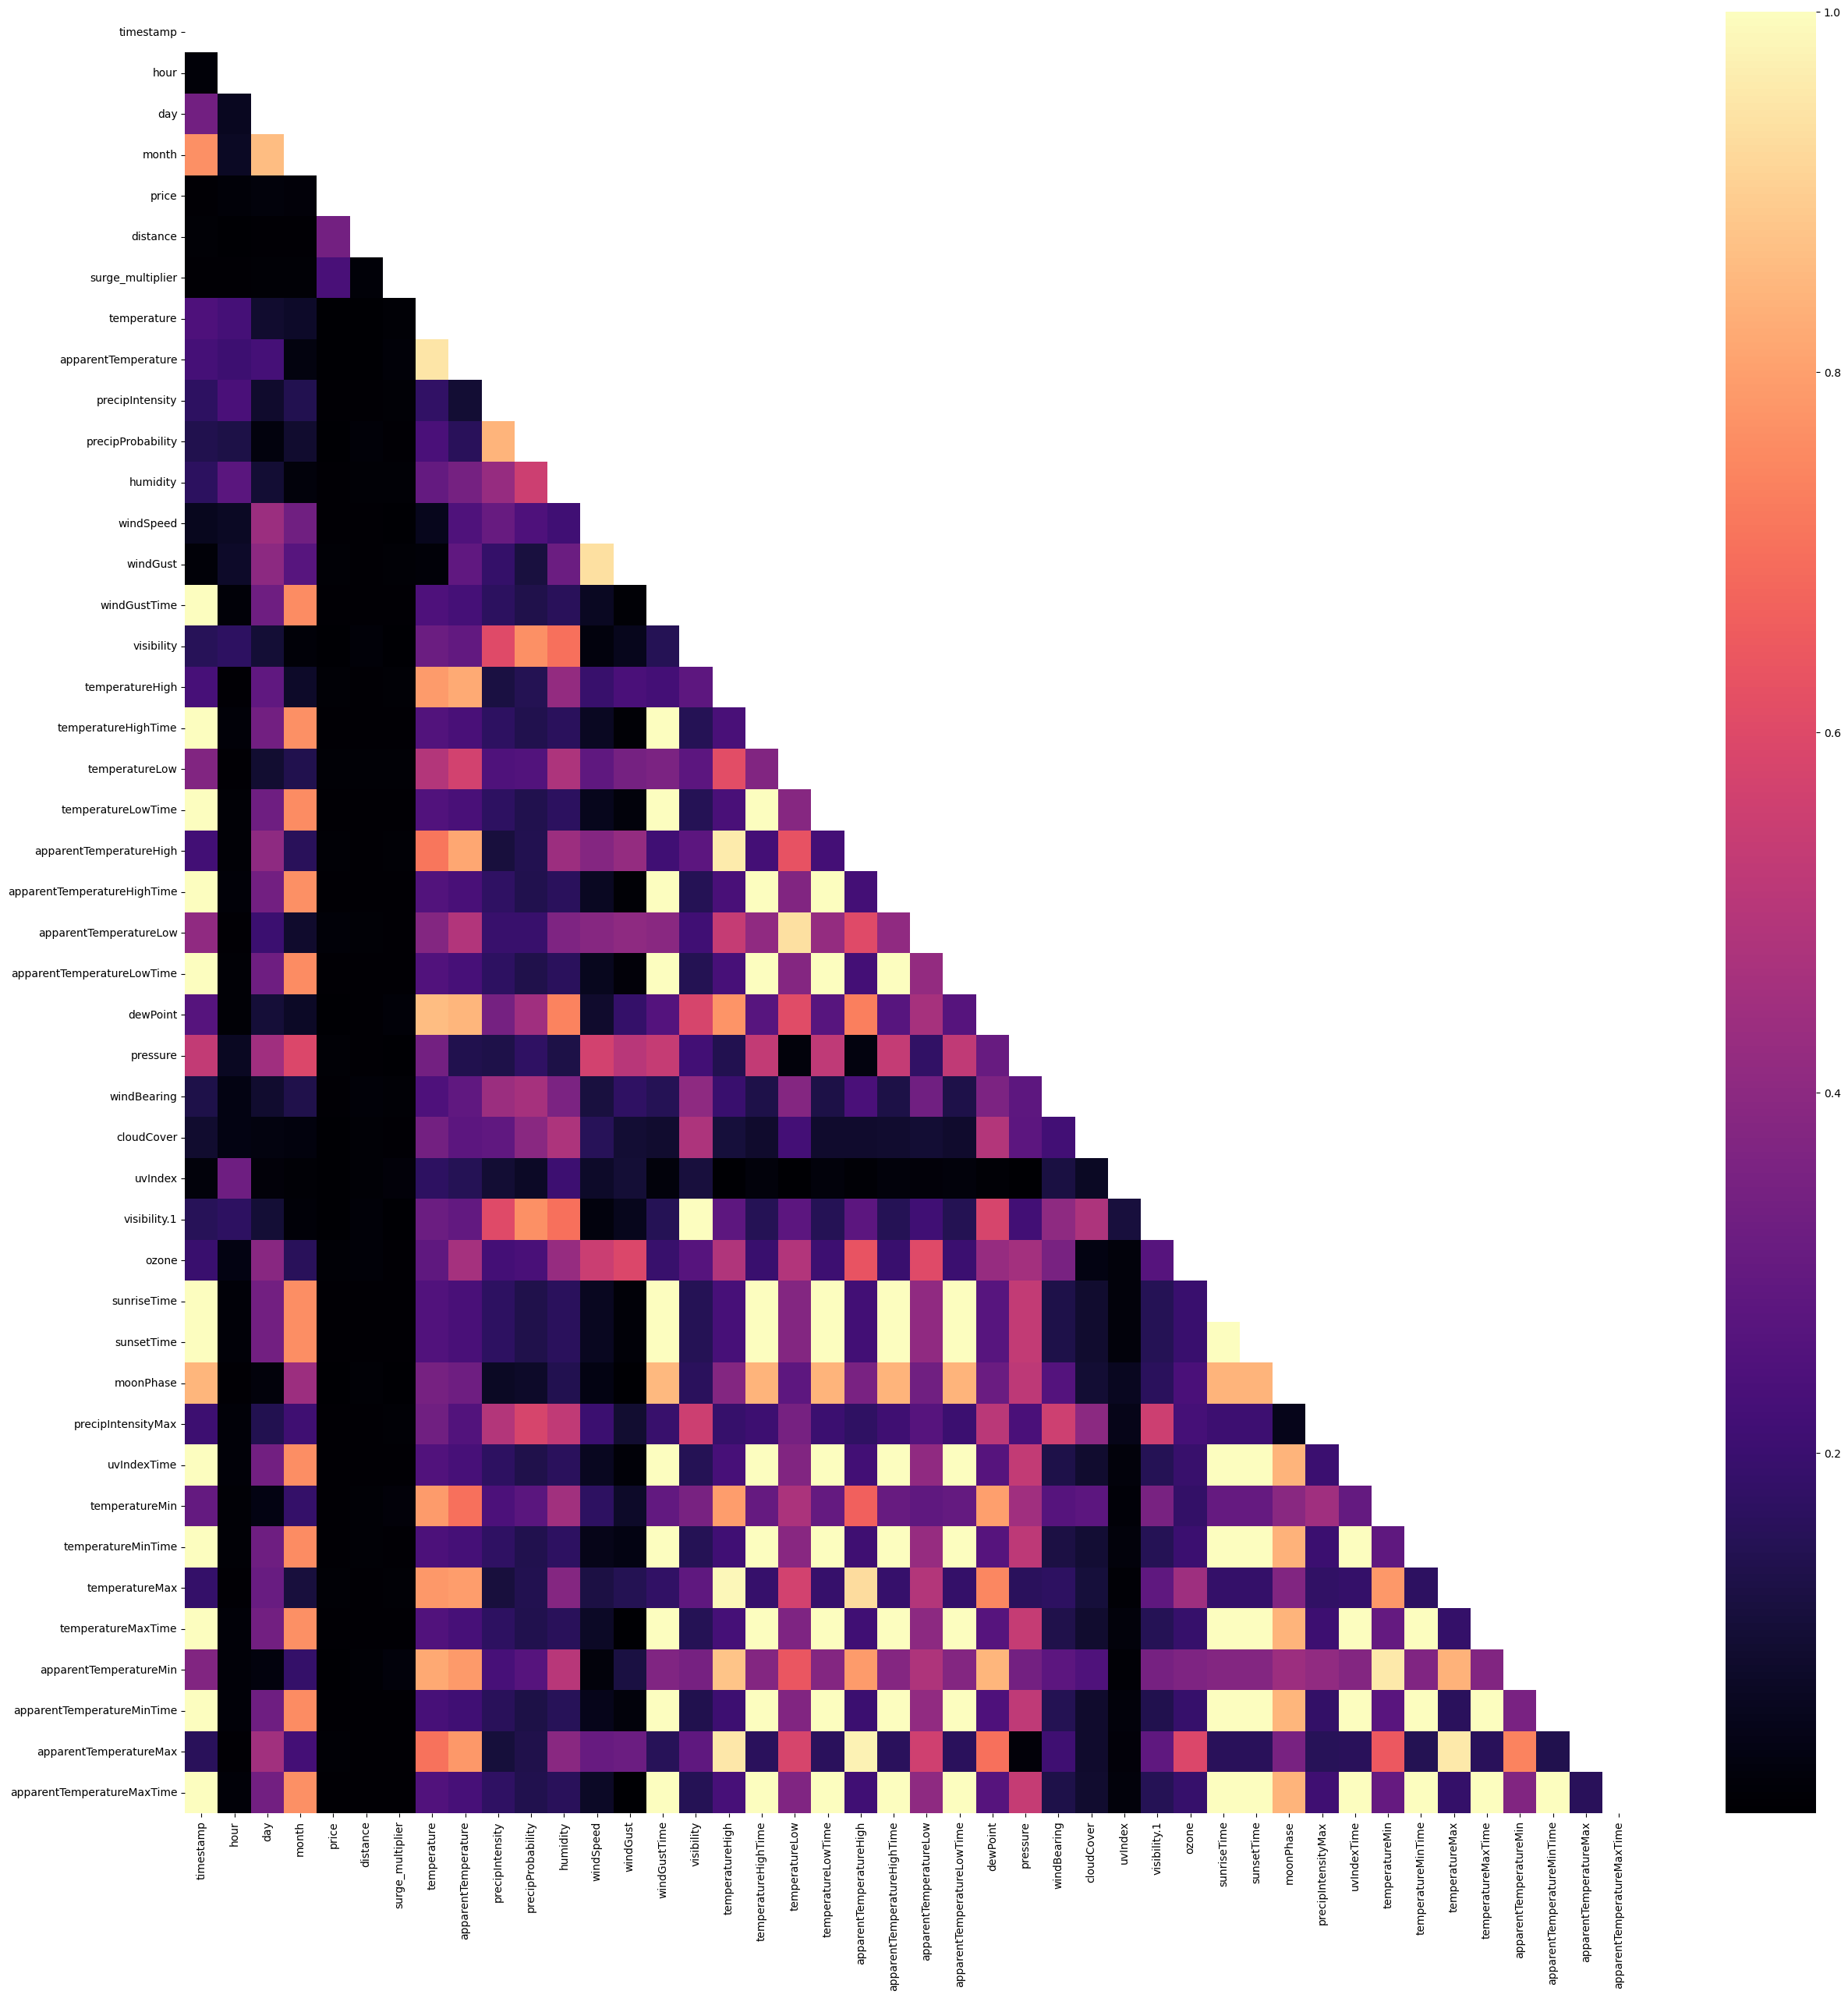

In [23]:
#Podemos verificar a correlação entre cada variavel pelo seaborn com o mapa de calor
import seaborn as sns
plt.figure(figsize=(30,30))
sns.heatmap(corr_num.abs(), mask=np.triu(np.ones_like(corr_num)), cmap='magma');

#### i) Encontre as variáveis que tem mais de 1% de correlação com a saída.Quais são elas? (variáveis numéricas mais correlacionadas)

In [24]:
#Realizamos uma querry dentro da variavel price em que pegamos apenas os valores maiores que 0.01 (1%)
var_corr1 = corr_num[target][corr_num[target] > 0.01] 
#Retiramos a variavel price da mesma
var_corr1.drop('price',inplace=True)
#Obtemos as colunas month, distance, surge_multiplier, temperatureLow, apparentTemperatureHigh, aparentTemperatureLow,apparentTemperatureMax.
var_corr1

month                      0.018830
distance                   0.338895
surge_multiplier           0.231704
temperatureLow             0.010459
apparentTemperatureHigh    0.010630
apparentTemperatureLow     0.014103
apparentTemperatureMax     0.011062
Name: price, dtype: float64

### b) Plote os gráficos de distribuição entre as variáveis categóricas e a saída (utilizar afunção boxplot do seaborn)

<Axes: xlabel='source', ylabel='price'>

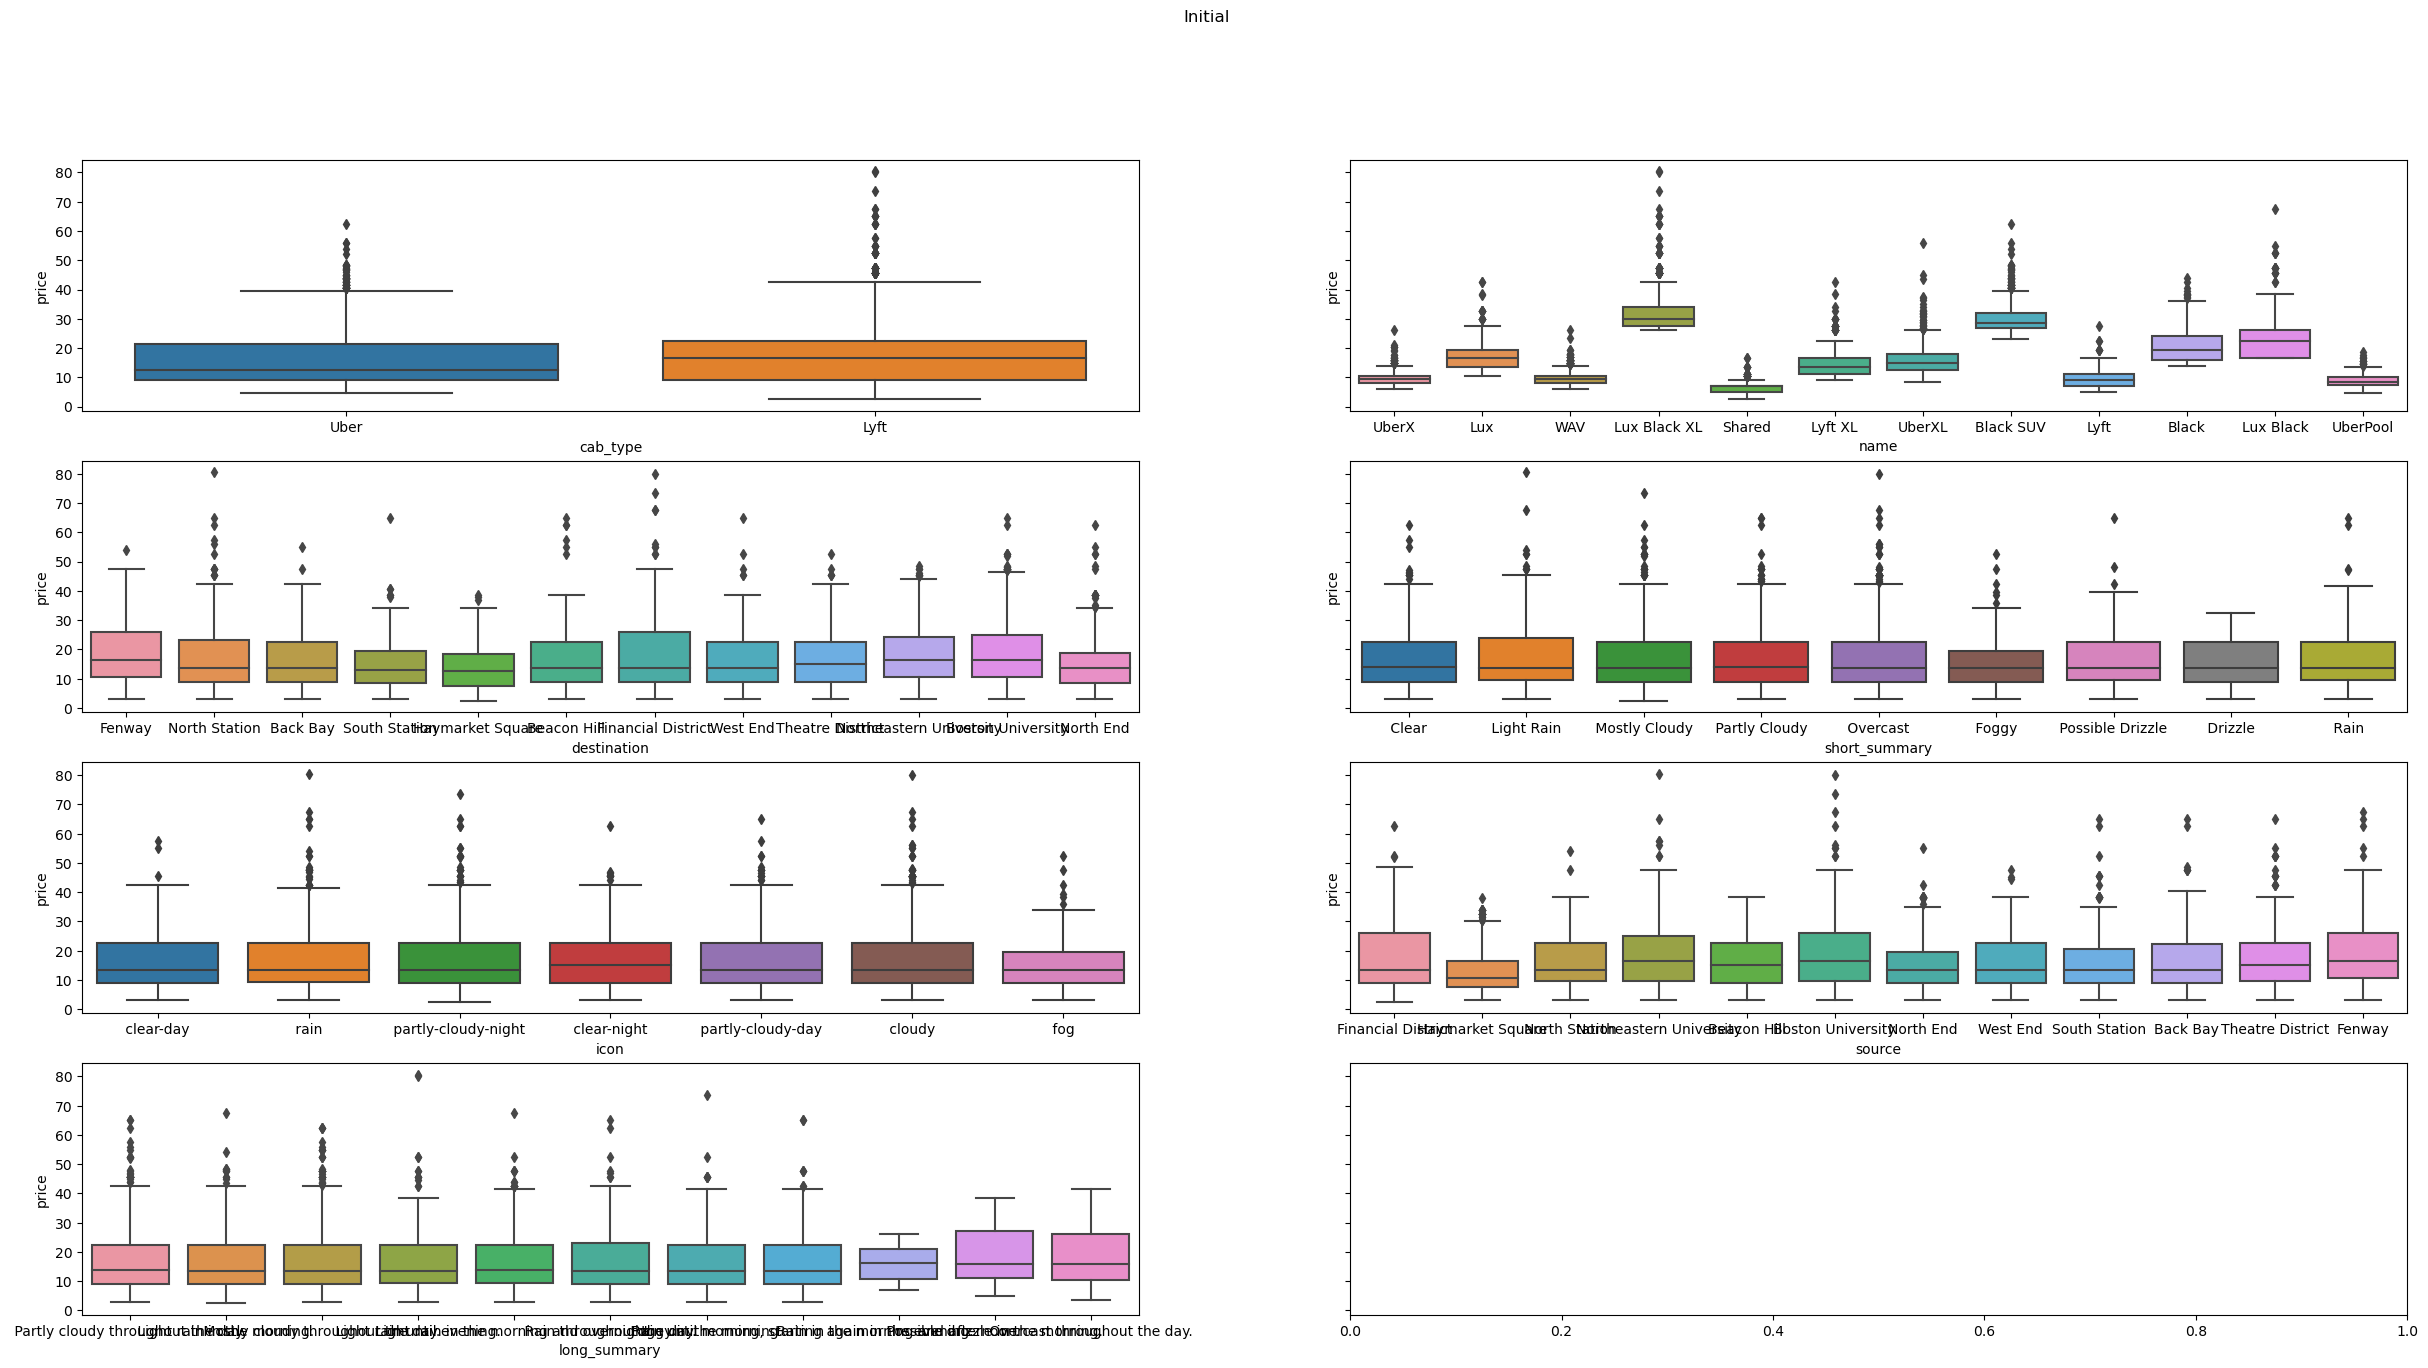

In [25]:
#Primeiro irei separar somente as variáveis categóricas

df_train_cate = df_train.select_dtypes(include='object')
cat_list = df_train_cate.columns


#Definindo o tamanho da figura e o número de eixos do plt.subplot
fig, axes = plt.subplots(4, 2, figsize=(30, 15), sharey=True)
fig.suptitle('Initial')

# Cab_type
sns.boxplot(ax=axes[(0,0)],x = df_train_cate["cab_type"],y=df_train[target])
# Cab_type
sns.boxplot(ax=axes[(1,0)],x = df_train_cate["destination"],y=df_train[target])
# Cab_type
sns.boxplot(ax=axes[(2,0)],x = df_train_cate["icon"],y=df_train[target])
# Cab_type
sns.boxplot(ax=axes[(3,0)],x = df_train_cate["long_summary"],y=df_train[target])
# Cab_type
sns.boxplot(ax=axes[(0,1)],x = df_train_cate["name"],y=df_train[target])
# Cab_type
sns.boxplot(ax=axes[(1,1)],x = df_train_cate["short_summary"],y=df_train[target])
# Cab_type
sns.boxplot(ax=axes[(2,1)],x = df_train_cate["source"],y=df_train[target])





### c) Comente a respeito do que foi observado

Podemos observar que apesar de termos diversas variáveis numéricas, a maioria tem uma influência muito baixa na saída
O mesmo acontece nas variáveis categóricas onde encontramos algumas variaveis que tem mais influência como o tipo de carro da corrida (black, normal etc) e outras com menos como a variavel de tempo

## Parte 5 - Treinamento de modelos: treinar nos dados de treinamento e avaliar no treinamento e validação


### a) Numéricas mais relevantes: Treine uma regressão linear com as variáveis numéricas da 4ai), da seguinte forma:

#### i) Primeiramente crie uma pipeline a partir do make_column_transformer e selecione as variáveis numéricas desejadas como entrada

In [26]:
num_features = ['month','distance','surge_multiplier','temperatureLow','apparentTemperatureHigh','apparentTemperatureLow','apparentTemperatureMax']
preprocess = make_column_transformer(('passthrough', num_features))

#### ii) Junte essa pipeline numérica com a regressão linear a partir da função make_pipeline

In [27]:
model = make_pipeline(preprocess, LinearRegression())

#### iii) Treine o modelo nos dados de treinamento

In [28]:
model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['month', 'distance',
                                                   'surge_multiplier',
                                                   'temperatureLow',
                                                   'apparentTemperatureHigh',
                                                   'apparentTemperatureLow',
                                                   'apparentTemperatureMax'])])),
                ('linearregression', LinearRegression())])

#### iv) Observe os resultados nos conjuntos de treinamento e validação (MAPE e MAE)

In [29]:
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.1%}')
print(f' Vali MAE: {mean_absolute_error(y_validation, model.predict(X_validation)):.2f}')
print(f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model.predict(X_validation)):.1%}')

Train MAE: 6.93
Train MAPE: 56.2%
 Vali MAE: 6.97
 Vali MAPE: 56.3%


#### v) Compare os resultados do modelo aplicando ou não o StandardScaler na pipeline de pré processamento

In [30]:
model = make_pipeline(preprocess, StandardScaler(), LinearRegression())

In [31]:
model.fit(X_train, y_train)
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.1%}')
print(f' Vali MAE: {mean_absolute_error(y_validation, model.predict(X_validation)):.2f}')
print(f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model.predict(X_validation)):.1%}')

Train MAE: 6.93
Train MAPE: 56.2%
 Vali MAE: 6.97
 Vali MAPE: 56.3%


#### vi) Comente os resultados obtidos

Verificamos que os resultados foram bem ruins e iguais para os dois casos, isso pelo fato que o linearRegression acaba não conseguindo muito bem realizar a predição e acaba resultando em um underfitting para o tipo os dados que temos
E também pelo fato de que os atributos numéricos acabaram não fornecendo uma correlação boa com a saída

### b) Categóricas: Repita o mesmo processo anterior somente para os atributos categóricos

#### i) Utilize a função OneHotEncoder para codificar os dados

In [32]:
cat_features = ['source', 'destination', 'cab_type', 'name', 'short_summary',
       'long_summary', 'icon'] #Obtendo todas as variáveis categóricas disponiveis no dataset

#Utilizando o oneHotEncoder em cima das variáveis categóricas como pré processamento
preprocess = make_column_transformer((OneHotEncoder(), cat_features))

In [33]:
cat_features

['source',
 'destination',
 'cab_type',
 'name',
 'short_summary',
 'long_summary',
 'icon']

In [34]:
model = make_pipeline(preprocess, LinearRegression())
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['source', 'destination',
                                                   'cab_type', 'name',
                                                   'short_summary',
                                                   'long_summary', 'icon'])])),
                ('linearregression', LinearRegression())])

In [35]:
len(list(preprocess.get_feature_names_out()))


65

In [36]:
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.1%}')
print(f' Vali MAE: {mean_absolute_error(y_validation, model.predict(X_validation)):.2f}')
print(f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model.predict(X_validation)):.1%}')

Train MAE: 2.69
Train MAPE: 18.6%
 Vali MAE: 2.73
 Vali MAPE: 18.7%


Podemos perceber que o resultado da predição saiu melhor do que o resultado das colunas numéricas, justamente pelos dados categóricos terem uma correlação linear maior com a saída do que os anteriores

### c) Numéricas mais relevantes + categóricas: Agora repita o mesmo processo utilizando todos os dados (numéricos (4ai) e categóricos)

In [37]:
#Como já temos separadas as variáveis categóricas e numéricas, podemos simplesmente alterar o preprocess para incluir as duas listas de variáveis
preprocess = make_column_transformer(('passthrough', num_features), (OneHotEncoder(), cat_features))

In [38]:
#Utilizando regressão linear
model = make_pipeline(preprocess, LinearRegression())

#Treinando o modelo
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['month', 'distance',
                                                   'surge_multiplier',
                                                   'temperatureLow',
                                                   'apparentTemperatureHigh',
                                                   'apparentTemperatureLow',
                                                   'apparentTemperatureMax']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['source', 'destination',
                                                   'cab_type', 'name',
                                                   'short_summary',
                                                   'long_summary', 'icon'])])),
                ('linearregression', LinearRegression())])

In [39]:
#Verificando resultados
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.1%}')
print(f' Vali MAE: {mean_absolute_error(y_validation, model.predict(X_validation)):.2f}')
print(f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model.predict(X_validation)):.1%}')

Train MAE: 1.75
Train MAPE: 13.3%
 Vali MAE: 1.77
 Vali MAPE: 13.3%


Comparando com os resultados anteriores, o resultado com ambas as variáveis numéricas (4ai) e categóricas tivemos um aumento no desempenho do modelo, com uma diminuição em todos os erros calculados. Comparando com os resultados das variáveis categóricas esse aumento foi pequeno mas considerável, apenas mais uma vez demosntrando que nessa base de dados as variáveis categóricas acabam sendo mais correlacionadas com a saída do que as numéricas (pelo menos a partir do ponto de vista linear)

### d) Todas as numéricas + categóricas: Repita o anterior, mas neste caso com todos os atributos (todos os numéricos e todos os categóricos e compare os resultados) (OBS: Espera-se que os resultados mantenham-se similares ao da letra 4c) e para manter o modelo mais simples, a partir desse ponto não serão utilizados todos os dados numéricos, mas somente os com maior correlação com a saída (4ai))

In [40]:
num_features_all = df_train.select_dtypes(exclude="object").columns.drop('price')
preprocess2 = make_column_transformer(('passthrough', num_features_all), (OneHotEncoder(), cat_features))

In [41]:
#Utilizando regressão linear
model = make_pipeline(preprocess2, LinearRegression())

#Treinando o modelo
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  Index(['timestamp', 'hour', 'day', 'month', 'distance', 'surge_multiplier',
       'temperature', 'apparentTemperature', 'precipIntensity',
       'precipProbability', 'humidity', 'windSpeed', 'windGust',
       'windGustTime', 'visibility', 'temperatureHigh', 'temperatureHighTime',
       'tempe...
       'temperatureMin', 'temperatureMinTime', 'temperatureMax',
       'temperatureMaxTime', 'apparentTemperatureMin',
       'apparentTemperatureMinTime', 'apparentTemperatureMax',
       'apparentTemperatureMaxTime'],
      dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['source', 'destination',
                                                   'cab_type', 'name',
                                                   'short_summary',
                                                   'long_summary', 'icon'])])),
                ('linearregression', LinearRegression())])

In [42]:
#Verificando resultados
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.1%}')
print(f' Vali MAE: {mean_absolute_error(y_validation, model.predict(X_validation)):.2f}')
print(f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model.predict(X_validation)):.1%}')

Train MAE: 1.75
Train MAPE: 13.3%
 Vali MAE: 1.77
 Vali MAPE: 13.3%


Podemos verificar que realmente o resultado ficou praticamente identico ao das variáveis numéricas com correlação acima de 1% (talvez com mais casas decimais pudesse ser vista alguma diferença)

### e) Polynomial features: Nesse momento, aplique polynomial features (com 3 valores distintos de d)

#### i) Aplique PolyFeatures somente nos dados numéricos (4ai) e junte com os dados categóricos no final da pipeline

In [43]:
#Utilizando o PolyFeatures apenas nos dados numéricos com d igual a 2,3 e 4
preprocess2 = make_column_transformer((PolynomialFeatures(2, include_bias=False), num_features), (OneHotEncoder(), cat_features))
preprocess3 = make_column_transformer((PolynomialFeatures(3, include_bias=False), num_features), (OneHotEncoder(), cat_features))
preprocess4 = make_column_transformer((PolynomialFeatures(4, include_bias=False), num_features), (OneHotEncoder(), cat_features))


#### ii) Utilize a regressão linear como regressão para essa etapa

In [44]:
#Utilizando regressão linear
model2 = make_pipeline(preprocess2, LinearRegression())
model3 = make_pipeline(preprocess3, LinearRegression())
model4 = make_pipeline(preprocess4, LinearRegression())
#Treinando o modelo
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=4,
                                                                     include_bias=False),
                                                  ['month', 'distance',
                                                   'surge_multiplier',
                                                   'temperatureLow',
                                                   'apparentTemperatureHigh',
                                                   'apparentTemperatureLow',
                                                   'apparentTemperatureMax']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['source', 'destination',
                                                   'cab_type', 'name',
                                                   'short_summary',
                                                   'long_summary', 'icon'])])),
                ('linearregression', LinearRegression())])

#### iii) Treine o modelo e observe os resultados conforme os itens anteriores

In [45]:
#Verificando resultados
print('D = 2')
print(f'Train MAE: {mean_absolute_error(y_train, model2.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model2.predict(X_train)):.1%}')
print(f' Vali MAE: {mean_absolute_error(y_validation, model2.predict(X_validation)):.2f}')
print(f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model2.predict(X_validation)):.1%}')

print('D = 3')
print(f'Train MAE: {mean_absolute_error(y_train, model3.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model3.predict(X_train)):.1%}')
print(f' Vali MAE: {mean_absolute_error(y_validation, model3.predict(X_validation)):.2f}')
print(f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model3.predict(X_validation)):.1%}')

print('D = 4')
print(f'Train MAE: {mean_absolute_error(y_train, model4.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model4.predict(X_train)):.1%}')
print(f' Vali MAE: {mean_absolute_error(y_validation, model4.predict(X_validation)):.2f}')
print(f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model4.predict(X_validation)):.1%}')

D = 2
Train MAE: 1.73
Train MAPE: 13.1%
 Vali MAE: 1.75
 Vali MAPE: 13.2%
D = 3
Train MAE: 1.70
Train MAPE: 12.9%
 Vali MAE: 1.75
 Vali MAPE: 13.2%
D = 4
Train MAE: 1.67
Train MAPE: 12.8%
 Vali MAE: 2.72
 Vali MAPE: 20.4%


Podemos ver que a partir de D > 3 começamos a causar um overffiting no modelo o que acaba aumentando gradualmente os erros de validação, por isso definirei D=3 como sendo o ótimo

### f) Poly + Ridge: Aplique o modelo Ridge em conjunto aos casos de polinomialfeatures do exercício passado ao invés da regressão linear simples e analise os resultados para ao menos 9 possíveis valores de hiperparâmetros 

In [46]:

alfa = (7e-5,3e-5,1e-5,7e-4,3e-4,1e-4,7e-3,3e-3,1e-3)
for a in alfa:
    #Utilizando regressão linear
    model2 = make_pipeline(preprocess2, Ridge(a))
    model3 = make_pipeline(preprocess3, Ridge(a))
    model4 = make_pipeline(preprocess4, Ridge(a))
    #Treinando o modelo
    model2.fit(X_train, y_train)
    model3.fit(X_train, y_train)
    model4.fit(X_train, y_train)
    
    
    print('alfa: ', a)
    #Verificando resultados
    print('D = 2',
          f'Train MAE: {mean_absolute_error(y_train, model2.predict(X_train)):.2f}',
          f'Train MAPE: {mean_absolute_percentage_error(y_train, model2.predict(X_train)):.1%}',
          f' Vali MAE: {mean_absolute_error(y_validation, model2.predict(X_validation)):.2f}',
          f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model2.predict(X_validation)):.1%}')

    print('D = 3',
        f'Train MAE: {mean_absolute_error(y_train, model3.predict(X_train)):.2f}',
        f'Train MAPE: {mean_absolute_percentage_error(y_train, model3.predict(X_train)):.1%}',
        f' Vali MAE: {mean_absolute_error(y_validation, model3.predict(X_validation)):.2f}',
        f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model3.predict(X_validation)):.1%}')

    print('D = 4',
          f'Train MAE: {mean_absolute_error(y_train, model4.predict(X_train)):.2f}',
          f'Train MAPE: {mean_absolute_percentage_error(y_train, model4.predict(X_train)):.1%}',
          f' Vali MAE: {mean_absolute_error(y_validation, model4.predict(X_validation)):.2f}',
          f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model4.predict(X_validation)):.1%}')


alfa:  7e-05
D = 2 Train MAE: 1.73 Train MAPE: 13.1%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 3 Train MAE: 1.71 Train MAPE: 12.9%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 4 Train MAE: 1.67 Train MAPE: 12.8%  Vali MAE: 1.85  Vali MAPE: 13.8%
alfa:  3e-05
D = 2 Train MAE: 1.73 Train MAPE: 13.1%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 3 Train MAE: 1.71 Train MAPE: 12.9%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 4 Train MAE: 1.67 Train MAPE: 12.8%  Vali MAE: 1.87  Vali MAPE: 13.8%
alfa:  1e-05
D = 2 Train MAE: 1.73 Train MAPE: 13.1%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 3 Train MAE: 1.71 Train MAPE: 12.9%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 4 Train MAE: 1.67 Train MAPE: 12.8%  Vali MAE: 2.08  Vali MAPE: 15.5%
alfa:  0.0007
D = 2 Train MAE: 1.73 Train MAPE: 13.1%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 3 Train MAE: 1.71 Train MAPE: 12.9%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 4 Train MAE: 1.68 Train MAPE: 12.9%  Vali MAE: 1.81  Vali MAPE: 13.6%
alfa:  0.0003
D = 2 Train MAE: 1.73 Train MAPE: 13.1%  Vali

c:\Users\Bruno\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.13997e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


alfa:  0.007
D = 2 Train MAE: 1.73 Train MAPE: 13.1%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 3 Train MAE: 1.71 Train MAPE: 12.9%  Vali MAE: 1.75  Vali MAPE: 13.1%
D = 4 Train MAE: 1.68 Train MAPE: 12.9%  Vali MAE: 1.81  Vali MAPE: 13.6%
alfa:  0.003
D = 2 Train MAE: 1.73 Train MAPE: 13.1%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 3 Train MAE: 1.71 Train MAPE: 12.9%  Vali MAE: 1.75  Vali MAPE: 13.1%
D = 4 Train MAE: 1.68 Train MAPE: 12.9%  Vali MAE: 1.82  Vali MAPE: 13.6%
alfa:  0.001
D = 2 Train MAE: 1.73 Train MAPE: 13.1%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 3 Train MAE: 1.71 Train MAPE: 12.9%  Vali MAE: 1.75  Vali MAPE: 13.2%
D = 4 Train MAE: 1.68 Train MAPE: 12.9%  Vali MAE: 1.82  Vali MAPE: 13.6%


In [47]:
#Melhor modelo:
model3 = make_pipeline(preprocess3, Ridge(0.007))
model3.fit(X_train, y_train)

print('D = 3',
        f'Train MAE: {mean_absolute_error(y_train, model3.predict(X_train)):.5f}',
        f'Train MAPE: {mean_absolute_percentage_error(y_train, model3.predict(X_train)):.5%}',
        f' Vali MAE: {mean_absolute_error(y_validation, model3.predict(X_validation)):.5f}',
        f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model3.predict(X_validation)):.5%}')

c:\Users\Bruno\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.13997e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


D = 3 Train MAE: 1.70549 Train MAPE: 12.94830%  Vali MAE: 1.74527  Vali MAPE: 13.14454%


    O melhor resultado obtido foi:

    alfa:  0.007
    D = 3   
    MAE: 1.70550 Train MAPE: 12.94829%  Vali MAE: 1.74527  Vali MAPE: 13.14458%

### g) TTR + Poly + Ridge: Aplique o TransformTargetRegressor no melhor modelo encontrado na letra 5f)

In [48]:
# Melhor modelo encontrado
alfa = 0.007
d = 3

#Preprocess continua igual
preprocess = make_column_transformer((PolynomialFeatures(d, include_bias=False), num_features), (OneHotEncoder(), cat_features))
#Incluimos durante a pipeline o TTR em cima do modelo ridge como uma func logaritma
model = make_pipeline(preprocess, TransformedTargetRegressor(Ridge(alfa), func=np.log, inverse_func=np.exp))
#Treinando o modelo
model.fit(X_train, y_train)
print(' ')

c:\Users\Bruno\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.13997e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [49]:
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.5f}',
      f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.5%}',
      f' Vali MAE: {mean_absolute_error(y_validation, model.predict(X_validation)):.5f}',
      f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model.predict(X_validation)):.5%}')


Train MAE: 1.37469 Train MAPE: 9.42021%  Vali MAE: 1.41590  Vali MAPE: 9.74462%


    Podemos verificar que a inclusão do TTR acabou melhorando ainda mais o melhor modelo encontrado anteriormente, onde o mesmo diminuiu consideravelmente ambos os MAPE e MAEs o que era de ser esperado, pois é justamente esse o intuito de se aplicar o TTR 

#### i) Adicione uma camada StandardScaler após o pré-processamento e antes do modelo Transform Target Regressor

In [50]:
""" Para isso colocamos o StandardScaler dentro da pipeline e após o preprocess, assim como requisitado """
alfa = 0.007
d = 3


preprocess = make_column_transformer((PolynomialFeatures(d, include_bias=False), num_features), (OneHotEncoder(), cat_features))

#Agora adicionei o standardScaler após o preprocess como pode ser visto abaixo
model = make_pipeline(preprocess, StandardScaler(), TransformedTargetRegressor(Ridge(alfa), func=np.log, inverse_func=np.exp))

#Treinando o modelo
model.fit(X_train, y_train)
print(' ')


In [51]:
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.5f}',
      f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.5%}',
      f' Vali MAE: {mean_absolute_error(y_validation, model.predict(X_validation)):.5f}',
      f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model.predict(X_validation)):.5%}')

Train MAE: 1.37470 Train MAPE: 9.42467%  Vali MAE: 1.41401  Vali MAPE: 9.72515%


Mais uma vez os erros MAE e MAPE diminuiram porém a diferença foi menor do que quando foi incluso o TTR

##### ii) Explique o que muda com a aplicação do TTR e como isso favorece a métrica que queremos otimizar

        Com a aplicação do TTR a saída fica sendo o logaritmo neperiano do preço do imóvel. Com isso conseguimos favorecer a métrica MAPE, pois agora mesma está verificando o erro relativo na previsão do preço, evitado dar peso ecessivo aos preços mais altos e pouco peso aos preços baixos.

### h) TTR + Ridge: Aplique o TransformTargetRegressor em um modelo Ridge com os dados numéricos de maior correlação (4ai) e os categóricos e compare os resultados com a 5g)

#### i) Lembre de aplicar StandardScaler nos atributos numéricos

In [52]:
alfa = 0.007
d = 3


preprocess = make_column_transformer((StandardScaler(),num_features), (OneHotEncoder(), cat_features))

#Agora adicionei o standardScaler após o preprocess como pode ser visto abaixo
model = make_pipeline(preprocess, TransformedTargetRegressor(Ridge(alfa), func=np.log, inverse_func=np.exp))

#Treinando o modelo
model.fit(X_train, y_train)
print(' ')

In [53]:
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.5f}',
      f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.5%}',
      f' Vali MAE: {mean_absolute_error(y_validation, model.predict(X_validation)):.5f}',
      f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model.predict(X_validation)):.5%}')

Train MAE: 1.43201 Train MAPE: 9.72052%  Vali MAE: 1.44965  Vali MAPE: 9.91169%


## Parte 6 Comparação de modelos

### a) Avalie o modelo treinado na 5h): tanto para o conjunto de treinamento e validação

#### i) Para o dataset completo (como foi feito até o momento)

    Verificamos que nesse caso em comparação com o modelo sem TTR ele também tem um desempenho melhor, porém não atingiu o desempenho do TTR+Poly+Ridge por um valor insignificante

    Train MAE: 1.43197 Train MAPE: 9.72035%  Vali MAE: 1.44962  Vali MAPE: 9.91167%    <----- TTR+ Riddge

    Train MAE: 1.37468 Train MAPE: 9.42020%  Vali MAE: 1.41590  Vali MAPE: 9.74464%    <----- TTR + Poly + Riddge


#### ii) Para o subconjunto somente com as corridas do Uber

In [54]:
#Precisamos separar os dados por instância novamente porém agora somente nas corridas do uber

# parâmetros
num_instancias_por_classe = 3000

#Selecionei apenas os ubers
df_uber = df[df['cab_type'] == 'Uber']


# cria datasets auxiliares para reduzir o dataset para o tamanho desejado
df_temp = []
for classe in df_uber['name'].unique():
    # seleciona parcela do dataset da classe desejada
    temp = df_uber[df_uber['name'] == classe].sample(n=num_instancias_por_classe,random_state=42)
    # salva para concatenar no final
    df_temp.append(temp)
    # concatena todos as subparcelas no dataset com tamanho desejado
df_small_uber = pd.concat(df_temp, axis=0)
# confirma a divisão correta por classe
print('-'*30)
print('#instâncias em relação a coluna name')
print(df_small_uber['name'].value_counts())
print('-'*30)
# mostra o dataset
df_small_uber

------------------------------
#instâncias em relação a coluna name
UberXL       3000
Black        3000
UberX        3000
WAV          3000
Black SUV    3000
UberPool     3000
Name: name, dtype: int64
------------------------------


,timestamp,hour,day,month,source,destination,cab_type,name,price,distance,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
401589,1.543640e+09,4,1,12,Financial District,Fenway,Uber,UberXL,22.5,4.48,...,0.0003,1543593600,28.68,1543575600,42.58,1543600800,27.26,1543568400,40.53,1543611600
505528,1.543359e+09,22,27,11,North Station,South Station,Uber,UberXL,14.5,2.17,...,0.1422,1543338000,35.90,1543377600,46.72,1543320000,31.81,1543377600,43.70,1543320000
423221,1.544850e+09,5,15,12,North End,Financial District,Uber,UberXL,11.5,1.04,...,0.0074,1544893200,39.54,1544929200,54.47,1544896800,36.46,1544929200,53.80,1544896800
24325,1.543660e+09,10,1,12,Northeastern University,West End,Uber,UberXL,16.5,2.86,...,0.0000,1543683600,31.26,1543658400,44.80,1543690800,27.76,1543658400,44.13,1543690800
379947,1.543367e+09,1,28,11,Northeastern University,North Station,Uber,UberXL,18.0,3.20,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641728,1.544756e+09,2,14,12,Boston University,North Station,Uber,UberPool,9.0,3.39,...,0.0001,1544716800,18.24,1544688000,33.96,1544731200,13.72,1544688000,32.95,1544734800
440208,1.544725e+09,18,13,12,Financial District,South Station,Uber,UberPool,6.5,0.47,...,0.0001,1544720400,17.85,1544688000,33.78,1544731200,13.73,1544688000,33.11,1544731200
37155,1.544895e+09,17,15,12,West End,Haymarket Square,Uber,UberPool,11.0,0.72,...,0.0077,1544893200,39.80,1544929200,54.29,1544896800,36.78,1544929200,53.62,1544896800
314283,1.543643e+09,5,1,12,Fenway,Back Bay,Uber,UberPool,7.0,1.60,...,0.0000,1543683600,31.55,1543658400,44.72,1543690800,27.95,1543658400,44.05,1543690800


In [55]:
df_uber_train, df_uber_test = train_test_split(df_small_uber, test_size=1/3, stratify=df_small_uber['name'], random_state=42)
df_uber_train, df_uber_validation = train_test_split(df_uber_train, test_size=0.5, stratify=df_uber_train['name'], random_state=42)

target = 'price' #Definindo a coluna que será predita
X_uber_train = df_uber_train.drop(target, axis=1) # X vai ser todas as colunas menos a coluna target
y_uber_train = df_uber_train[target] # y será apenas a coluna target


X_uber_test = df_uber_test.drop(target, axis=1)
y_uber_test = df_uber_test[target]


X_uber_validation = df_uber_validation.drop(target, axis=1)
y_uber_validation = df_uber_validation[target]

In [56]:
alfa = 0.007
d = 3


preprocess = make_column_transformer(('passthrough', num_features),(StandardScaler(),num_features), (OneHotEncoder(), cat_features))

#Agora adicionei o standardScaler após o preprocess como pode ser visto abaixo
model = make_pipeline(preprocess, TransformedTargetRegressor(Ridge(alfa), func=np.log, inverse_func=np.exp))

#Treinando o modelo
model.fit(X_uber_train, y_uber_train)
print(' ')

In [57]:
print(f'Train MAE: {mean_absolute_error(y_uber_train, model.predict(X_uber_train)):.5f}',
      f'Train MAPE: {mean_absolute_percentage_error(y_uber_train, model.predict(X_uber_train)):.5%}',
      f' Vali MAE: {mean_absolute_error(y_uber_validation, model.predict(X_uber_validation)):.5f}',
      f' Vali MAPE: {mean_absolute_percentage_error(y_uber_validation, model.predict(X_uber_validation)):.5%}')

Train MAE: 1.40535 Train MAPE: 9.15261%  Vali MAE: 1.43120  Vali MAPE: 9.30101%


    Verificamos que apenas com o cab_type == uber obtivemos um resultado melhor com um erro MAPE menor mas apesar disto, obtivemos um MAE maior em comparação com todos os outros dados (TTR+Poly+Ridge). Outra questão é como nos dados apenas do Uber o resultado foi um pouco melhor do que com todos os dados, podemos ter um feeling de que o treinamento do Lyft será um pouco pior, pois assim colocando os dois juntos daria uma "média" dos dois MAPEs, como dito isso é apenas um "feeling"

    Train MAE: 1.43197 Train MAPE: 9.72035%  Vali MAE: 1.44962  Vali MAPE: 9.91167%    <----- TTR+ Riddge

    Train MAE: 1.37468 Train MAPE: 9.42020%  Vali MAE: 1.41590  Vali MAPE: 9.74464%    <----- TTR + Poly + Riddge

    Train MAE: 1.40535 Train MAPE: 9.15261%  Vali MAE: 1.43120  Vali MAPE: 9.30101%    <----- TTR + Poly + Riddge APENAS Na UBER

#### iii) Para o subconjunto somente com as corridas do Lyft

In [58]:
#Precisamos separar os dados por instância novamente porém agora somente nas corridas do lyft

# parâmetros
num_instancias_por_classe = 3000

#Selecionei apenas os ubers
df_lyft = df[df['cab_type'] == 'Lyft']


# cria datasets auxiliares para reduzir o dataset para o tamanho desejado
df_temp = []
for classe in df_lyft['name'].unique():
    # seleciona parcela do dataset da classe desejada
    temp = df_lyft[df_lyft['name'] == classe].sample(n=num_instancias_por_classe,random_state=42)
    # salva para concatenar no final
    df_temp.append(temp)
    # concatena todos as subparcelas no dataset com tamanho desejado
df_small_lyft = pd.concat(df_temp, axis=0)
# confirma a divisão correta por classe
print('-'*30)
print('#instâncias em relação a coluna name')
print(df_small_lyft['name'].value_counts())
print('-'*30)
# mostra o dataset
df_small_lyft

------------------------------
#instâncias em relação a coluna name
Shared          3000
Lux             3000
Lyft            3000
Lux Black XL    3000
Lyft XL         3000
Lux Black       3000
Name: name, dtype: int64
------------------------------


,timestamp,hour,day,month,source,destination,cab_type,name,price,distance,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
277878,1.543296e+09,5,27,11,North End,West End,Lyft,Shared,2.5,1.27,...,0.1430,1543338000,36.34,1543377600,47.11,1543320000,32.26,1543377600,44.14,1543320000
284360,1.544902e+09,19,15,12,Northeastern University,North Station,Lyft,Shared,7.0,3.26,...,0.0082,1544893200,39.74,1544929200,54.29,1544896800,37.04,1544929200,53.62,1544896800
322047,1.543466e+09,4,29,11,Fenway,Back Bay,Lyft,Shared,3.5,1.52,...,0.0000,1543420800,33.70,1543399200,42.60,1543438800,29.88,1543399200,36.56,1543435200
226416,1.543358e+09,22,27,11,North End,Beacon Hill,Lyft,Shared,7.0,2.39,...,0.1422,1543338000,35.90,1543377600,46.72,1543320000,31.81,1543377600,43.70,1543320000
324330,1.543718e+09,2,2,12,Theatre District,Northeastern University,Lyft,Shared,9.0,2.94,...,0.0000,1543683600,30.17,1543662000,44.11,1543690800,25.87,1543662000,43.44,1543690800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293956,1.543868e+09,20,3,12,North Station,Northeastern University,Lyft,Lux Black,32.5,3.35,...,0.0004,1543852800,42.83,1543896000,57.52,1543852800,39.65,1543896000,56.85,1543852800
53845,1.544943e+09,6,16,12,Haymarket Square,Theatre District,Lyft,Lux Black,16.5,1.23,...,0.1246,1544979600,38.94,1544954400,43.78,1544990400,33.76,1545019200,38.39,1544986800
621824,1.543814e+09,5,3,12,Financial District,Northeastern University,Lyft,Lux Black,26.0,3.43,...,0.0004,1543852800,42.83,1543896000,57.52,1543852800,39.65,1543896000,56.85,1543852800
596379,1.543217e+09,7,26,11,North Station,Boston University,Lyft,Lux Black,27.5,3.09,...,0.1225,1543251600,40.45,1543233600,46.49,1543255200,37.17,1543291200,43.84,1543244400


In [59]:
df_lyft_train, df_lyft_test = train_test_split(df_small_lyft, test_size=1/3, stratify=df_small_lyft['name'], random_state=42)
df_lyft_train, df_lyft_validation = train_test_split(df_lyft_train, test_size=0.5, stratify=df_lyft_train['name'], random_state=42)

target = 'price' #Definindo a coluna que será predita
X_lyft_train = df_lyft_train.drop(target, axis=1) # X vai ser todas as colunas menos a coluna target
y_lyft_train = df_lyft_train[target] # y será apenas a coluna target


X_lyft_test = df_lyft_test.drop(target, axis=1)
y_lyft_test = df_lyft_test[target]


X_lyft_validation = df_lyft_validation.drop(target, axis=1)
y_lyft_validation = df_lyft_validation[target]

In [60]:
alfa = 0.007
d = 3


preprocess = make_column_transformer(('passthrough', num_features),(StandardScaler(),num_features), (OneHotEncoder(), cat_features))

#Agora adicionei o standardScaler após o preprocess como pode ser visto abaixo
model = make_pipeline(preprocess, TransformedTargetRegressor(Ridge(alfa), func=np.log, inverse_func=np.exp))

#Treinando o modelo
model.fit(X_lyft_train, y_lyft_train)
print(' ')

In [61]:
print(f'Train MAE: {mean_absolute_error(y_lyft_train, model.predict(X_lyft_train)):.5f}',
      f'Train MAPE: {mean_absolute_percentage_error(y_lyft_train, model.predict(X_lyft_train)):.5%}',
      f' Vali MAE: {mean_absolute_error(y_lyft_validation, model.predict(X_lyft_validation)):.5f}',
      f' Vali MAPE: {mean_absolute_percentage_error(y_lyft_validation, model.predict(X_lyft_validation)):.5%}')

Train MAE: 1.37237 Train MAPE: 9.85037%  Vali MAE: 1.38615  Vali MAPE: 10.16419%


    Como pode ser visto os resultados do Lyft obtiveram um MAE menor, por outro lado um MAPE maior do que em todos os outros modelos com TTR, confirmamos aqui o "feeling" descrito na seção do uber e podemos dizer que as corridas de Lyft tem um desempenho pior nos modelos utilizados (isso utilizando a métrica do MAPE).

    Train MAE: 1.43197 Train MAPE: 9.72035%  Vali MAE: 1.44962  Vali MAPE: 9.91167%    <----- TTR+ Riddge

    Train MAE: 1.37468 Train MAPE: 9.42020%  Vali MAE: 1.41590  Vali MAPE: 9.74464%    <----- TTR + Poly + Riddge

    Train MAE: 1.40535 Train MAPE: 9.15261%  Vali MAE: 1.43120  Vali MAPE: 9.30101%    <----- TTR + Poly + Riddge APENAS UBER

    Train MAE: 1.37237 Train MAPE: 9.85037%  Vali MAE: 1.38615  Vali MAPE: 10.16419%   <----- TTR + Poly + Riddge APENAS Lyft
    

#### iv) Mostre os atributos mais importantes

In [62]:
#Estou utilizando o modelo da 5)h
alfa = 0.007
d = 3

preprocess = make_column_transformer((StandardScaler(),num_features), (OneHotEncoder(), cat_features))

#Agora adicionei o standardScaler após o preprocess como pode ser visto abaixo
model = make_pipeline(preprocess, TransformedTargetRegressor(Ridge(alfa), func=np.log, inverse_func=np.exp))

#Treinando o modelo
model.fit(X_train, y_train)
print(' ')


In [63]:
# Obtém os coeficientes do modelo que é o último item da pipeline por isso o -1
coef = model[-1].regressor_.coef_

# Separa os coeficientes das colunas numéricas e categóricas
coef_num = coef[:len(num_features)]
coef_cat = coef[len(num_features):]

# Obtém os índices dos atributos numéricos mais importantes
idx_num = np.argsort(-np.abs(coef_num))[:2]

# Obtém os índices dos atributos categóricos mais importantes
idx_cat = np.argsort(-np.abs(coef_cat))[:3]


# Imprime os atributos mais importantes (item i e ii requisitados)
print("Top 2 atributos numéricos:")
for idx in idx_num:
    print(f"{num_features[idx]}: {coef_num[idx]}")

print('\n')

print("Top 3 atributos categóricos:")
for idx in idx_cat:
    print(f"{list(preprocess.transformers_[1][1].get_feature_names_out())[idx]}: {coef_cat[idx]}")

Top 2 atributos numéricos:
distance: 0.19670941327123057
surge_multiplier: 0.06780868203955388


Top 3 atributos categóricos:
name_Shared: -0.9109598796912981
name_Lux Black XL: 0.7775277369065355
name_Black SUV: 0.7707846554237103


    Os dois atributos numéricos mais impactantes foram o distance e surge_multiplier, fato que realmente faz sentido na base de quanto maior a distância da corrida tem uma relação praticamente linear com o custo do aplicativo e a mesma coisa acontece com o multiplicador do preço, como o próprio nome já diz é um fator que multiplica o preço de acordo com a oferta/demanda

    Já os 3 categóricos mais importantes foram o name_Shared considerada a forma mais barata de viagem onde você compartilha o carro com outras pessoas desconhecidas, fazendo sentido influenciar diretamente no preço
    O Lux Black XL é um dos tipos de veiculos mais caros também, justamente pelo conforto e pelo espaço
    O Black SUV é pelo menos motivo da variável acima

### b) Retreine o modelo da letra 6a) somente para as corridas de Uber, avalie seu resultado neste dataset e compare com o modelo da 6a)

In [64]:
#Estou utilizando o modelo da 5)h
alfa = 0.007
d = 3

preprocess = make_column_transformer((StandardScaler(),num_features), (OneHotEncoder(), cat_features))

#Agora adicionei o standardScaler após o preprocess como pode ser visto abaixo
model = make_pipeline(preprocess, TransformedTargetRegressor(Ridge(alfa), func=np.log, inverse_func=np.exp))

#Treinando o modelo com apenas os dados dos carros da Uber
model.fit(X_uber_train, y_uber_train)
print(' ')

In [65]:
# Obtém os coeficientes do modelo que é o último item da pipeline por isso o -1
coef = model[-1].regressor_.coef_

# Separa os coeficientes das colunas numéricas e categóricas
coef_num = coef[:len(num_features)]
coef_cat = coef[len(num_features):]

# Obtém os índices dos atributos numéricos mais importantes
idx_num = np.argsort(-np.abs(coef_num))[:2]

# Obtém os índices dos atributos categóricos mais importantes
idx_cat = np.argsort(-np.abs(coef_cat))[:3]


# Imprime os atributos mais importantes (item i e ii requisitados)
print("Top 2 atributos numéricos:")
for idx in idx_num:
    print(f"{num_features[idx]}: {coef_num[idx]}")

print('\n')

print("Top 3 atributos categóricos:")
for idx in idx_cat:
    print(f"{list(preprocess.transformers_[1][1].get_feature_names_out())[idx]}: {coef_cat[idx]}")

Top 2 atributos numéricos:
distance: 0.18134469155761296
apparentTemperatureHigh: -0.011063154730067207


Top 3 atributos categóricos:
name_Black SUV: 0.769451528633367
name_UberPool: -0.4795218951513093
name_WAV: -0.3836884278646226


    Temos agora a distancia sempre a mais importante e a temperatura alta com um fator negativo no preço do uber
    Agora temos apenas as categorias de nome dos carros do Uber como era de se esperar, sendo que o UberPool seria um sinonimo do Shared do lyft e por isso o sinal negativo
    Já o uber WAV é para pessoas com cadeira de rodas e nas regras do uber fala que você não irá pagar mais do que um UberX (que é uma das categorias mais baratas de Uber)

### c) Repita o caso anterior, mas para o dataset do Lyft ao invés do Uber

In [66]:
#Estou utilizando o modelo da 5)h
alfa = 0.007
d = 3

preprocess = make_column_transformer((StandardScaler(),num_features), (OneHotEncoder(), cat_features))

#Agora adicionei o standardScaler após o preprocess como pode ser visto abaixo
model = make_pipeline(preprocess, TransformedTargetRegressor(Ridge(alfa), func=np.log, inverse_func=np.exp))

#Treinando o modelo com apenas os dados dos carros da Uber
model.fit(X_lyft_train, y_lyft_train)
print(' ')

In [67]:
# Obtém os coeficientes do modelo que é o último item da pipeline por isso o -1
coef = model[-1].regressor_.coef_

# Separa os coeficientes das colunas numéricas e categóricas
coef_num = coef[:len(num_features)]
coef_cat = coef[len(num_features):]

# Obtém os índices dos atributos numéricos mais importantes
idx_num = np.argsort(-np.abs(coef_num))[:2]

# Obtém os índices dos atributos categóricos mais importantes
idx_cat = np.argsort(-np.abs(coef_cat))[:3]


# Imprime os atributos mais importantes (item i e ii requisitados)
print("Top 2 atributos numéricos:")
for idx in idx_num:
    print(f"{num_features[idx]}: {coef_num[idx]}")

print('\n')

print("Top 3 atributos categóricos:")
for idx in idx_cat:
    print(f"{list(preprocess.transformers_[1][1].get_feature_names_out())[idx]}: {coef_cat[idx]}")

Top 2 atributos numéricos:
distance: 0.22161912459158128
surge_multiplier: 0.09610165444908272


Top 3 atributos categóricos:
name_Shared: -0.915861151314727
name_Lux Black XL: 0.776130847845173
name_Lyft: -0.4494152654472214


### d) Comente sobre os atributos mais importantes e se isso é coerente com a sua intuição sobre o tema

    Como comentado acima todos os dados obtidos fazem sentido, pelo menos na minha intuição.
    Também o fato do uber não conter a opção Shared a mesma não altera nesses casos

## Parte 7 Análise de resultados: Utilizando o modelo da 5h) (StandardScaler nos dados numéricos, dados numéricos mais correlacionados 4ai), TransformTargetRegressor e Ridge)


In [68]:
#Mesmo modelo utilizado na 5)h

alfa = 0.007
d = 3

#Coloquei o StandardScaler somente nas variáveis numericas
preprocess = make_column_transformer((StandardScaler(),num_features), (OneHotEncoder(), cat_features))

#Criando um modelo na pipeline
model = make_pipeline(preprocess, TransformedTargetRegressor(Ridge(alfa), func=np.log, inverse_func=np.exp))

#Treinando o modelo
model.fit(X_train, y_train)
print(' ')

### a) Avalie o resultado do modelo para o conjunto de teste (MAPE)

In [69]:
print('Train e Validação')
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.5f}',
      f'Train MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.5%}',
      f' Vali MAE: {mean_absolute_error(y_validation, model.predict(X_validation)):.5f}',
      f' Vali MAPE: {mean_absolute_percentage_error(y_validation, model.predict(X_validation)):.5%}')

Train e Validação
Train MAE: 1.43201 Train MAPE: 9.72052%  Vali MAE: 1.44965  Vali MAPE: 9.91169%


In [70]:
print('Teste')
print(f' Test MAPE: {mean_absolute_percentage_error(y_test, model.predict(X_test)):.5%}')

Teste
 Test MAPE: 9.80271%


    Obtive um MAPE de teste menor do que o de validação e um pouco maior do que o de treinamento utilizando o modelo 5h

### b) Trace um gráfico de dispersão entre os valores preditos e reais para o conjunto do teste

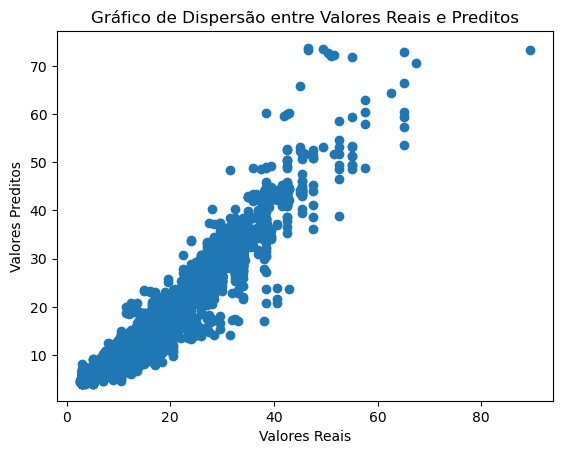

In [71]:
# Obter previsões para o conjunto de teste
y_pred = model.predict(X_test)

# Traçar o gráfico de dispersão entre os valores preditos e reais
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Gráfico de Dispersão entre Valores Reais e Preditos')
plt.show()

    Observasse que contém uma previsão menor em valores mais baixos e pior em valores mais altos, provavelmente pela falta de dados em corridas com valores muito altos, pois até as mesmas são mais raras de acontecer (distâncias muito longas e/ou multipliers muito elevados)

## Parte 8 Discussão

#### a) Comentários gerais sobre os resultados

    Acredito que os resultados foram bons, porém podiam ser melhorados. Isso não no fato dos modelos terem sido ineficientes, mas sim no fato dos dados utilizados para o treinamento do mesmo.
    Os modelos utilizados (tirando os mais simples) foram todos com resultados semelhantes, alguns melhores em poucos % do que os outros sendo o TTR + Poly + Ridge o modelo de melhor desempenho mas ao mesmo tempo de maior cálculo computacional como era esperado
    Acredito que pela má escolha dos dados, acabamos tendo poucos valores altos de preço e por isso o modelo não funcionou muito bem para prever valores altos de preço
    Por fim acredito que mesmo tendo filtrado as variaveis utilizadas no treinamento acredito que ainda sim ficaram variaveis com bastante correlação uma com a outra (principalmente as categóricas) o que pode ter impactado negativamente no desempenho dos modelos

#### b) Comentários gerais sobre o trabalho, aprendizado, dúvidas e outros

    Achei o trabalho bem interessante porém muito extenso, foi a primeira vez que utilizei meus conhecimentos de machine learning de maneira mais complexa e me encontrei diversas vezes travado em algum tópico, ao mesmo tempo que depois de fazer e refazer diversas vezes acabava encontrando um erro que eu tinha cometido anteriormente e assim tendo que refazer boa parte do trabalho.
    Por ser um trabalho muito extenso, mesmo tendo feito ele com bastante tempo acabei ficando bem saturado do conhecimento e na minha opnião a minha performace foi diminuindo no decorrer do trabalho.
    No final acredito que estou um pouco exausto mas que provavelmente depois de um certo tempo irei conseguir absorver todo o conteúdo do trabalho, o qual aparentemente conseguiu validar todas as aulas até então
    Como já dito anteriormente no decorrer do trabalho tive várias e várias dúvidas mas indo atrás da informação na internet e com outros colegas consegui tirar as mesmas. Espero que esteja tudo certo.

    Acredito que se de alguma forma o trabalho fosse um pouco menos extenso (principalmente considerando que este é o primeiro trabalho e nem todo mundo sabia programar em Python e muito menos mexer com essas bibliotecas que o professor passou nas aulas) seria mais fácil absorver o conteúdo. Mas no fim acredito que será extremamente importante para mim e estou bem realizado que consegui finalizar esse trabalho.